# Final Project : Multi-scale Clustering Analysis of Wildfire Hazards and Machine Learning-based Burn Severity Prediction

Minho Kim (PhD, Landscape Architecture and Environmental Planning)
Keats Hua (Masters, Civil and Environmetnal Engineering)

## Required libraries and dependencies

In [1]:
import rasterio, os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import warnings
import time

warnings.filterwarnings("ignore")
plt.rcParams["figure.autolayout"] = True

## Main functions

In [2]:
# Image processing functions

# Open single band data (eg. DEM, LULC, etc)
def open_data(img_path):
    with rasterio.open(img_path, 'r') as src:
        img = src.read(1)
        meta = src.meta
    return img, meta

# Open multispectral imagery (eg. Sentinel-2 10 bands, Planetscope 4-band)
def open_multiband(img_path):
    with rasterio.open(img_path, 'r') as src:
        b = src.read(1) #blue
        g = src.read(2) #green
        r = src.read(3) #red
        n = src.read(4) #near infrared
        meta = src.meta
    img = np.dstack((b,g,r,n)) # This is a 4band image in b,g,r,n
    
    return img, meta

# Clip % of data histogram for visualization (For satellite images)
def clip(img, percentile):
    out = np.zeros_like(img.shape[2])
    for i in range(img.shape[2]):
        a = 0 
        b = 255 
        c = np.percentile(img[:,:,i], percentile)
        d = np.percentile(img[:,:,i], 100 - percentile)        
        t = a + (img[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        img[:,:,i] =t
    rgb_out = img.astype(np.uint8)   
    return rgb_out

def minmax(img):
    return (img - np.nanmin(img)) / (np.nanmax(img) + np.nanmin(img))

def standardize(img):
    stdev_img = np.nanstd(img)
    mean_img = np.nanmean(img)
    
    return (img - mean_img) / stdev_img

def plot_img(img, form):
    
    plt.figure(figsize = (12,10))
    
    # Assuming band order : B-G-R-NIR 
    if form == 'rgb':
        plt.imshow(np.dstack((img[:,:,2], img[:,:,1], img[:,:,0])))
                   
    elif form == 'false':
        plt.imshow(np.dstack((img[:,:,3], img[:,:,2], img[:,:,1])))
    
    plt.colorbar()
    
    
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproj_img(input_img, dst_crs):
#     reproj_img(img,'EPSG:4326')
    with rasterio.open(input_img) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
    
        output_img = input_img.split('.')[0]+'_reproj.tif'
    
        with rasterio.open(output_img, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
                
# dst_crs = 'EPSG:4326'
# output_img = 'bs00_test.tif'

def reproj_from(input_img, transform_img, dst_crs):

    with rasterio.open(transform_img) as img_src:
        img_transform, img_width, img_height = calculate_default_transform(
            img_src.crs, dst_crs, img_src.width, img_src.height, *img_src.bounds)

    with rasterio.open(input_img) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()

        kwargs.update({
            'crs': img_src.crs,
            'transform': img_transform,
            'width': img_width,
            'height': img_height
        })

        output_img = input_img.split('.')[0]+'_reproj.tif'
        with rasterio.open(output_img, 'w', **kwargs) as dst:
#             for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=img_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
    
    
def resize(input_img, transform_img):
    with rasterio.open(transform_img) as transform_src:
        transform_img = transform_src.read(1)
        transform_meta = transform_src.meta.copy()
    
    transform_meta
    
    with rasterio.open(input_img) as src:
        w = src.read(1, window=Window(0, 0, width, height))
        profile = src.profile
        profile['width'] = width
        profile['height'] = height

        # Create output
        result = numpy.full((width, height), dtype=profile['dtype'], fill_value=profile['nodata'])
        output_img = input_img.split('.')[0]+'_resized.tif'
    
    # Write
    with rasterio.open(output_img, 'w', **profile) as dataset:
        dataset.write_band(1, result)


## Input Paths and Data
* Change data paths to local

In [3]:
path = '/Users/minho/Desktop/CE263/Project/datasets/'

# Input image paths
os.chdir(path)

img_train = sorted(glob.glob('s2*.tif'))
dem_train = sorted(glob.glob('dem*.tif'))
slope_train = sorted(glob.glob('slope*.tif'))
aoi_train = sorted(glob.glob('fire*.tif'))
lulc_train = sorted(glob.glob('lulc*.tif'))

# Weather data
rmin_train = sorted(glob.glob('rmin*.tif'))
rmax_train = sorted(glob.glob('rmax*.tif'))
tmmn_train = sorted(glob.glob('tmmn*.tif'))
tmmx_train = sorted(glob.glob('tmmx*.tif'))
vs_train = sorted(glob.glob('vs*.tif'))

In [4]:
# Input Parameters
number_of_sample_points = 10000 # This selects the number of samples from each burn severity class
random_state = 42 # Random seed number to keep consistent
input_bands = 10 # Number of features in the training dataset (10) and with weather (10 + 5)

patch_size = 10 # Patch size (Order of neighboring pixels - eg. 10 = 10x10 patch)

## Burn Severity AOI Processing (Ground Truth)

In [5]:
# Loop through all directories and search for files with extension .tif
burn_sev_list = glob.glob(os.path.join(path,'fire*.tif'))
print('Number of burn severity AOIs :', len(burn_sev_list))

Number of burn severity AOIs : 37


# Part 1: Burn Severity Prediction Using Random Forest and Determining Feature Importance

In [6]:
# Create input dataset stack

img_size_list = []

for i in range(len(img_train)):
    img, img_meta = open_multiband(img_train[i])    
    img_size_list.append(img.shape[0]*img.shape[1])    
    
del img_meta 

img_size_df = pd.DataFrame(columns = ['size', 'weight','weighted_pix', 'low','low-med','med-high','high'])
img_size_df.size = img_size_list
# img_size_df.reset_index(level=0, inplace=True)

In [7]:
# Random sampling for each image (based on AOI size and burn severity class frequency)

for i in range(len(img_size_df)):
    img_size_df['weight'][i] = img_size_df['size'][i]/img_size_df['size'].sum()
    img_size_df['weighted_pix'][i] = img_size_df['weight'][i]*100

    aoi, aoi_meta = open_data(aoi_train[i])
    aoi[aoi > 4] = 0 # Set nodata values to 0 or NaN
    
    img_size_df['low'][i] = len(aoi[aoi==1])
    img_size_df['low-med'][i] = len(aoi[aoi==2])
    img_size_df['med-high'][i] = len(aoi[aoi==3])
    img_size_df['high'][i] = len(aoi[aoi==4])
    
del aoi_meta

## Sampling
- Total samples: 10,000 samples (points at 10m resolution) with 2,500 samples for each burn severity class
- Split: Frequency relative to total pixel count for each burn severity class
- Method: Random sampling 

In [8]:
burn_sev_df = img_size_df.copy().drop(columns = ['size','weight','weighted_pix'])

for i in range(len(img_size_df)):
    burn_sev_df['low'][i] = img_size_df['low'][i]/img_size_df['low'].sum()*number_of_sample_points
    burn_sev_df['low-med'][i] = img_size_df['low-med'][i]/img_size_df['low-med'].sum()*number_of_sample_points
    burn_sev_df['med-high'][i] = img_size_df['med-high'][i]/img_size_df['med-high'].sum()*number_of_sample_points
    burn_sev_df['high'][i] = img_size_df['high'][i]/img_size_df['high'].sum()*number_of_sample_points

## Training Data

In [9]:
# Input bands and images

def input_data(method):
    
    '''
    Sampling Method # 1 : Random sampling based on wildfire size
    - Split burn severity AOIs in terms of wildfire size (to avoid bias in weightings)
    - Sample based on relative pixel count

    Sampling Method # 2 : Fixed random sampling sets 
    - Sample fixed number for each burn severity class
    * Same number of samples for all AOIs and across burn severity classes

    Sampling Method # 3 : Sampling by superpixel
    - SLIC
    - Grouby SLIC and random sample

    Sampling Method # 4 : Patch samples 
    '''
    
    # Open input datasets for each AOI
    img_t, meta_img = open_multiband(img_train[i])
    dem_t, meta_dem = open_data(dem_train[i])
    slope_t, meta_slope = open_data(slope_train[i])
    lulc_t, meta_lulc = open_data(lulc_train[i])

    ndvi_t = (img_t[:,:,3]/65535 - img_t[:,:,2]/65535) / (img_t[:,:,3]/65535 + img_t[:,:,2]/65535)
    savi=((img_t[:,:,3]/65535 - img_t[:,:,2]/65535)/(img_t[:,:,3]/65535 +img_t[:,:,2]/65535 +0.5))*(1+0.5)
    
    ndvi_t[ndvi_t < 0.2] = 0
    
    lulc_t[lulc_t == 10] = 1
    lulc_t[lulc_t == 20] = 2
    lulc_t[lulc_t == 30] = 3
    lulc_t[lulc_t == 40] = 4 
    lulc_t[lulc_t == 95]= 5
    lulc_t[lulc_t == 50]= 0
    lulc_t[lulc_t == 60]= 0
    lulc_t[lulc_t == 70]= 0
    lulc_t[lulc_t == 80]= 0
    lulc_t[lulc_t == 90]= 0
    lulc_t[lulc_t == 100]= 0

    x, y = np.gradient(dem_t)
    aspect = np.arctan2(-x, y)
    del x,y

    img_stack = np.dstack((minmax(img_t), 
                           minmax(ndvi_t), 
                           minmax(savi), 
                           minmax(dem_t), 
                           minmax(slope_t), 
                           aspect, 
                           lulc_t))   
    
    
    
    if method == 1:
        return img_stack, meta_img
    
    if method == 4:
        # Zero-padding for input datasets (for patch-based sampling)
        pad_width = int(patch_size/2), int(patch_size/2)
        img_padded = np.pad(img_stack, pad_width=[pad_width,pad_width,(0,0)], mode='constant')
        return img_padded
        

def input_data_patches(method):
    
    # Open input datasets for each AOI
    img_t, meta_img = open_multiband(img_train[i])
    dem_t, meta_dem = open_data(dem_train[i])
    slope_t, meta_slope = open_data(slope_train[i])

    ndvi_t = (img_t[:,:,3]/65535 - img_t[:,:,2]/65535) / (img_t[:,:,3]/65535 + img_t[:,:,2]/65535)
    savi=((img_t[:,:,3]/65535 - img_t[:,:,2]/65535)/(img_t[:,:,3]/65535 +img_t[:,:,2]/65535 +0.5))*(1+0.5)
    
    ndvi_t[ndvi_t < 0.2] = 0

    # Blue, Green, Red, NIR, NDVI, SAVI, DEM, Slope
    img_stack = np.dstack((minmax(img_t), 
                           minmax(ndvi_t), 
                           minmax(savi), 
                           minmax(dem_t), 
                           minmax(slope_t), 
                           ))    
    
    if method == 1:
        return img_stack, meta_img
    
    if method == 4:
        # Zero-padding for input datasets (for patch-based sampling)
        pad_width = int(patch_size/2), int(patch_size/2)
        img_padded = np.pad(img_stack, pad_width=[pad_width,pad_width,(0,0)], mode='constant')
        return img_padded
     

        
# Read all pixels for each burn severity class
def read_aoi(aoi_img):
    
    aoi_t, aoi_meta = open_data(aoi_img)
    aoi_t[aoi_t > 4] = 0 # Set nodata values to 0 or NaN

    aoi_low = np.copy(aoi_t)
    aoi_low[aoi_low > 1] = 0

    aoi_mlow = np.copy(aoi_t)
    aoi_mlow[aoi_mlow != 2] = 0

    aoi_mhigh = np.copy(aoi_t)
    aoi_mhigh[aoi_mhigh != 3] = 0

    aoi_high = np.copy(aoi_t)
    aoi_high[aoi_high != 4] = 0
    
    return aoi_t, aoi_low, aoi_mlow, aoi_mhigh, aoi_high


# Method 1 : Random Sampling 
def aoi_sampling(img_stack, aoi_class, sev_num, sample_count, random_state, img_stack_meta):

    # Set mask based on burn severity class: Low = 1 / Med-Low = 2 / Med-High = 3 / High = 4
    aoi_mask = np.where(aoi_class == sev_num)

    # Create AOI df to input random sampling data
    aoi_df = pd.DataFrame()
    aoi_df['c1'] = aoi_mask[0]
    aoi_df['c2'] = aoi_mask[1]
    sampled_aois = aoi_df.sample(n=sample_count, replace=True, random_state=random_state) # Randomly sampled AOI coordinates
#     sampled_aois.reset_index(inplace=False, drop=True)
    
    # Empty placers for sampled features
    sampled_aois['features'] = np.zeros(sampled_aois.shape[0])
    sampled_features = []
    lons, lats = [],[]
    
    # Extract features (as points) from stacked images using randomly sampled points
    for j in sampled_aois.index:
        img_stack_train = img_stack[aoi_df['c1'][j], aoi_df['c2'][j],:] 
        sampled_features.append(img_stack_train)
        
        lon,lat  = rasterio.transform.xy(img_stack_meta['transform'], aoi_df['c1'][j], aoi_df['c2'][j])
        lons.append(lon)
        lats.append(lat)
        
    # Resulting samples as a dataframe with features in a list format
    sampled_aois['longitude'] = lons
    sampled_aois['latitude'] = lats
    sampled_aois['features'] = sampled_features 
    
    return sampled_aois



# Method 2 : Fixed Sampling 
def fixed_sampling(img_stack, aoi_class, sev_num, sample_count, random_state):

    # Set mask based on burn severity class: Low = 1 / Med-Low = 2 / Med-High = 3 / High = 4
    aoi_mask = np.where(aoi_class == sev_num)

    # Create AOI df to input random sampling data
    aoi_df = pd.DataFrame()
    aoi_df['c1'] = aoi_mask[0]
    aoi_df['c2'] = aoi_mask[1]
    
    sampled_aois = aoi_df.sample(n=sample_count, replace=True, random_state=random_state) # Randomly sampled AOI coordinates
#     sampled_aois.reset_index(inplace=False, drop=True)
    
    # Empty placers for sampled features
    sampled_aois['features'] = np.zeros(sampled_aois.shape[0])
    sampled_features = []

    # Extract features (as points) from stacked images using randomly sampled points
    for j in sampled_aois.index:
        img_stack_train = img_stack[aoi_df['c1'][j], aoi_df['c2'][j],:] 
        sampled_features.append(img_stack_train)

    # Resulting samples as a dataframe with features in a list format
    sampled_aois['features'] = sampled_features 
    
    return sampled_aois

# Method 3 : Time-based random sampling
def time_sampling(img_stack, aoi_class, sev_num, sample_count, random_state, img_stack_meta):

    # Set mask based on burn severity class: Low = 1 / Med-Low = 2 / Med-High = 3 / High = 4
    aoi_mask = np.where(aoi_class == sev_num)

    # Create AOI df to input random sampling data
    aoi_df = pd.DataFrame()
    aoi_df['c1'] = aoi_mask[0]
    aoi_df['c2'] = aoi_mask[1]
    sampled_aois = aoi_df.sample(n=sample_count, replace=True, random_state=random_state) # Randomly sampled AOI coordinates
#     sampled_aois.reset_index(inplace=False, drop=True)
    
    # Empty placers for sampled features
    sampled_aois['features'] = np.zeros(sampled_aois.shape[0])
    sampled_features = []
    lons, lats = [],[]
    
    # Extract features (as points) from stacked images using randomly sampled points
    for j in sampled_aois.index:
        img_stack_train = img_stack[aoi_df['c1'][j], aoi_df['c2'][j],:] 
        sampled_features.append(img_stack_train)
        
        lon,lat  = rasterio.transform.xy(img_stack_meta['transform'], aoi_df['c1'][j], aoi_df['c2'][j])
        lons.append(lon)
        lats.append(lat)
        
    # Resulting samples as a dataframe with features in a list format
    sampled_aois['longitude'] = lons
    sampled_aois['latitude'] = lats
    sampled_aois['features'] = sampled_features 
     
    return sampled_aois

# Method 4 : Patch-based random sampling
def mean_sampling(img_stack, img_padded, aoi_class, sev_num, sample_count, patch_size, random_state):

    # Set mask based on burn severity class: Low = 1 / Med-Low = 2 / Med-High = 3 / High = 4
    aoi_mask = np.where(aoi_class == sev_num)

    # Create AOI df to input random sampling data
    aoi_df = pd.DataFrame()
    aoi_df['c1'] = aoi_mask[0]
    aoi_df['c2'] = aoi_mask[1]
    sampled_aois = aoi_df.sample(n=sample_count, replace=True, random_state=random_state) # Randomly sampled AOI coordinates

    # Empty placers for sampled features
    sampled_aois['features'] = np.zeros((sampled_aois.shape[0]))
    sampled_features, sampled_features1, sampled_features2 = [],[],[]

    # Extract features (as patches) from stacked images using randomly sampled points
    for j in sampled_aois.index:
        img_stack_train = img_stack[aoi_df['c1'][j], aoi_df['c2'][j],:] 
        sampled_features1.append(img_stack_train)
        
        centroid = aoi_df['c1'][j], aoi_df['c2'][j]
        low_b = int(centroid[0] - patch_size/2), int(centroid[0] + patch_size/2) 
        high_b = int(centroid[1] - patch_size/2), int(centroid[1] + patch_size/2)

        patchs = img_padded[low_b[0]:low_b[1], high_b[0]:high_b[1]]
        mean_patch = [np.nanmean(patchs[:,:,band]) for band in range(patchs.shape[2])]
        sampled_features2.append(mean_patch)
        
        sampled_features = list(np.hstack((sampled_features1,sampled_features2)))

    # Resulting samples as a dataframe with features in a list format
    sampled_aois['features'] = sampled_features
   
    return sampled_aois


# Method 4 : Patch-based random sampling
def patch_sampling(img_padded, aoi_class, sev_num, sample_count, patch_size, random_state):

    # Set mask based on burn severity class: Low = 1 / Med-Low = 2 / Med-High = 3 / High = 4
    aoi_mask = np.where(aoi_class == sev_num)

    # Create AOI df to input random sampling data
    aoi_df = pd.DataFrame()
    aoi_df['c1'] = aoi_mask[0]
    aoi_df['c2'] = aoi_mask[1]
    sampled_aois = aoi_df.sample(n=sample_count, replace=True, random_state=random_state) # Randomly sampled AOI coordinates

    # Empty placers for sampled features
    sampled_aois['features'] = np.zeros(sampled_aois.shape[0])
    sampled_features = []

    # Extract features (as patches) from stacked images using randomly sampled points
    for j in sampled_aois.index:

        centroid = aoi_df['c1'][j], aoi_df['c2'][j]
        low_b = int(centroid[0] - patch_size/2), int(centroid[0] + patch_size/2) 
        high_b = int(centroid[1] - patch_size/2), int(centroid[1] + patch_size/2)
        
#         print("Coordinates: ", low_b, high_b)
#         print("Patch size: ", low_b[1]-low_b[0], high_b[1]-high_b[0])

        patchs = img_padded[low_b[0]:low_b[1], high_b[0]:high_b[1]]
        sampled_features.append(patchs)

    # Resulting samples as a dataframe with features in a list format
    sampled_aois['features'] = sampled_features
   
    return sampled_aois

# Processing methods (Choose ONE)
- Method 0 : Patch based averages --> 18 features
- Method 1 : Random sampling --> 10 features
- Method 2 : Fixed sampling --> 10 features
- Method 3 : Random + Fixed sampling using dataset split in chronological order
- Method 4 : Patch sampling --> 10 features (for deep learning : creates 4d tensors)
** eg. (# samples, patch_x, patch_y, # features)

## Method 0 (Patch-based averages)
- 18 features

In [10]:
# Set AOI sample counts
df1 = burn_sev_df.round(0).astype(int)

feature_names = ['Blue','Green','Red','NIR','NDVI','SAVI','DEM','Slope','Aspect', 'LULC',
                'Blue_m','Green_m','Red_m','NIR_m','NDVI_m','SAVI_m','DEM_m','Slope_m']

# # Set empty placeholders for training dataset
low_train = pd.DataFrame(columns = ['c1','c2','features'])
mlow_train = pd.DataFrame(columns = ['c1','c2','features'])
mhigh_train = pd.DataFrame(columns = ['c1','c2','features'])
high_train = pd.DataFrame(columns = ['c1','c2','features'])


In [11]:
for i in range(len(df1)): # df1 = Dataframe with burn severity AOIs
    img_stack, _ = input_data(method=1)
    img_padded = input_data_patches(method=4)
 
    # Find required number of samples for each burn severity class
    aoi_t, aoi_low, aoi_mlow, aoi_mhigh, aoi_high = read_aoi(aoi_train[i])
    
    def random_patch_sample(sample_dataset, sev_dataset, clss, sev_num):
        # Number of samples to be selected for random sampling
        sample_count = sample_dataset[clss][i]
        # Random sampling for each burn severity class
        sev_df = mean_sampling(img_stack, img_padded, sev_dataset, sev_num, sample_count, patch_size, random_state)
        return sev_df

    # Extract random samples from each burn severity class
    low_df2 = random_patch_sample(df1, aoi_low, 'low', 1)
    mlow_df2 = random_patch_sample(df1, aoi_mlow, 'low-med', 2)
    mhigh_df2 = random_patch_sample(df1, aoi_mhigh, 'med-high', 3)
    high_df2 = random_patch_sample(df1, aoi_high, 'high', 4)
        
     # Add to training datasets
    low_train=low_train.append(low_df2)
    mlow_train=mlow_train.append(mlow_df2)
    mhigh_train=mhigh_train.append(mhigh_df2)
    high_train=high_train.append(high_df2)
    

In [12]:
def create_datasets(train_set,sev):
    train = train_set.reset_index(inplace=False, drop=True)
    train_dataset = pd.DataFrame(train["features"].to_list(), 
                                 columns=feature_names)
    return train_dataset

low_train = create_datasets(low_train, 1)
mlow_train = create_datasets(mlow_train, 2)
mhigh_train = create_datasets(mhigh_train, 3)
high_train = create_datasets(high_train, 4)

In [13]:
# If patches produce Nan values

training_dataset = np.vstack((low_train, mlow_train, mhigh_train, high_train))
todrop = [np.argwhere(np.isnan(training_dataset))[i][0] for i in range(len(np.argwhere(np.isnan(training_dataset))))]

training_dataset = pd.DataFrame(training_dataset)
training_dataset=training_dataset.drop(np.unique(todrop))

In [14]:
def create_gt(train_set, sev):
    gt_dataset = np.full((train_set.shape[0], 1), sev)
    return gt_dataset

low_gt = create_gt(low_train, 1)
mlow_gt = create_gt(mlow_train, 2)
mhigh_gt = create_gt(mhigh_train, 3)
high_gt = create_gt(high_train, 4)
gt_dataset = np.vstack((low_gt, mlow_gt, mhigh_gt, high_gt))


In [15]:
# If patches produce Nan values
gt_dataset = pd.DataFrame(gt_dataset)
gt_dataset=gt_dataset.drop(np.unique(todrop))

In [16]:
# Holdout sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_dataset, gt_dataset, test_size=0.2, random_state=random_state)

print("Training dataset size: ", len(X_train))
print("Test dataset size: ", len(X_test))

Training dataset size:  31948
Test dataset size:  7987


In [17]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

cr = classification_report(y_test, y_pred)
print(cr)

Accuracy: 0.60936521848003
              precision    recall  f1-score   support

           1       0.64      0.67      0.65      2039
           2       0.54      0.50      0.52      1906
           3       0.53      0.48      0.50      1973
           4       0.69      0.78      0.73      2069

    accuracy                           0.61      7987
   macro avg       0.60      0.61      0.60      7987
weighted avg       0.60      0.61      0.60      7987



In [20]:
feature_names = ['Blue','Green','Red','NIR','NDVI','SAVI','DEM','Slope','Aspect','LULC',
                'Blue_m','Green_m','Red_m','NIR_m','NDVI_m','SAVI_m','DEM_m','Slope_m']

# feature_names = [f"feature {i+1}" for i in range(training_dataset.shape[1])]

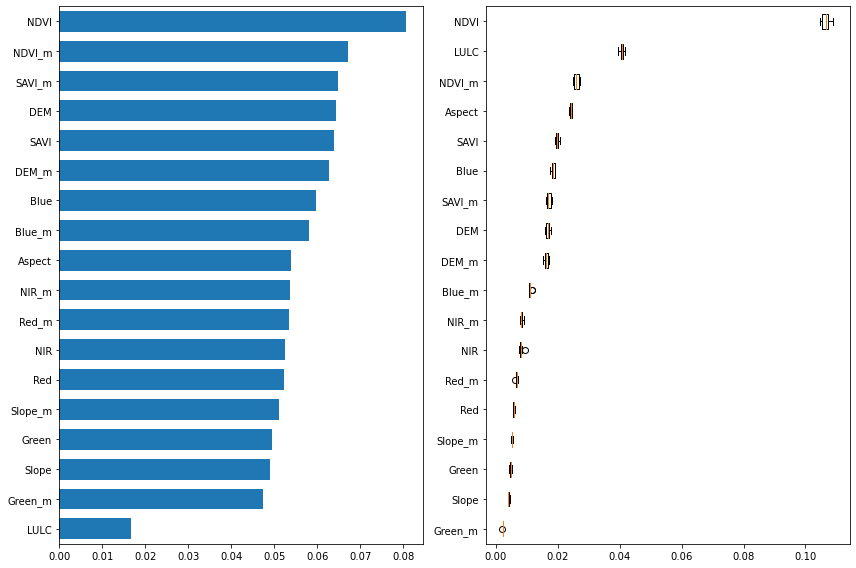

In [24]:
# Combination of MDI and permutation importance (Vertical graphs)

result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels([feature_names[i] for i in tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=[feature_names[i] for i in perm_sorted_idx],
)
fig.tight_layout()
plt.show()

## Set of all machine learning algorithms

In [25]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

clf_list = {
    'mlp': MLPClassifier(random_state=random_state, max_iter=1000),
    'gnb': GaussianNB(),
    'ada': AdaBoostClassifier(random_state=random_state),
    'gbc': GradientBoostingClassifier(random_state=random_state),
    'rf':  RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=random_state)
}
clf_df = []


def ml_classify(clf, clf_name):

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    print(key, "accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    cr = classification_report(y_test, y_pred, output_dict = True)
    df = pd.DataFrame(cr).transpose()
    
    return df


for key, classifier in clf_list.items():
    cr = ml_classify(classifier, key)
#     clf_df.append(key)
    clf_df.append(cr)

mlp accuracy: 0.5825716789783398
gnb accuracy: 0.4194315763115062
ada accuracy: 0.4819081006635783
gbc accuracy: 0.551270815074496
rf accuracy: 0.6053587079003381


In [ ]:
# Save files to folder

# clf_df[0].to_csv ('mlp_fixed.csv', index = False, header=True)
# clf_df[1].to_csv ('gnb_fixed.csv', index = False, header=True)
# clf_df[2].to_csv ('ada_fixed.csv', index = False, header=True)
# clf_df[3].to_csv ('gbc_fixed.csv', index = False, header=True)
# clf_df[4].to_csv ('rf_fixed.csv', index = False, header=True)

## Method 1: Random Sampling based on Wildfire Size

In [95]:
# Set AOI sample counts
df1 = burn_sev_df.round(0).astype(int)

# Set empty placeholders for training dataset
low_train = pd.DataFrame(columns = ['c1','c2','features'])
mlow_train = pd.DataFrame(columns = ['c1','c2','features'])
mhigh_train = pd.DataFrame(columns = ['c1','c2','features'])
high_train = pd.DataFrame(columns = ['c1','c2','features'])

In [96]:
# Method 1 : Random sampling
for i in range(len(df1)): # df1 = Dataframe with burn severity AOIs
   
    img_stack, img_stack_meta = input_data(method=1)
    
    # Find required number of samples for each burn severity class
    aoi_t, aoi_low, aoi_mlow, aoi_mhigh, aoi_high = read_aoi(aoi_train[i])

    def random_sample(sample_dataset, sev_dataset, clss, sev_num):
        # Number of samples to be selected for random sampling
        sample_count = sample_dataset[clss][i]
        # Random sampling for each burn severity class
        sev_df = aoi_sampling(img_stack, sev_dataset, sev_num, sample_count, random_state, img_stack_meta)
        return sev_df

    # Extract random samples from each burn severity class
    low_df = random_sample(df1, aoi_low, 'low', 1)
    mlow_df = random_sample(df1, aoi_mlow, 'low-med', 2)
    mhigh_df = random_sample(df1, aoi_mhigh, 'med-high', 3)
    high_df = random_sample(df1, aoi_high, 'high', 4)
    
    # Add to training datasets
    low_train=low_train.append(low_df)
    mlow_train=mlow_train.append(mlow_df)
    mhigh_train=mhigh_train.append(mhigh_df)
    high_train=high_train.append(high_df)


In [97]:
def create_datasets(train_set, sev):
    train = train_set.reset_index(inplace=False, drop=True)
    train_dataset = pd.DataFrame(train["features"].to_list(), columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
    train_dataset['latitude'] = train['latitude']
    train_dataset['longitude'] = train['longitude']

    gt_dataset = np.full((train_dataset.shape[0], 1), sev)
    
    return train_dataset, gt_dataset

low_train, low_gt = create_datasets(low_train, 1)
mlow_train, mlow_gt = create_datasets(mlow_train, 2)
mhigh_train, mhigh_gt = create_datasets(mhigh_train, 3)
high_train, high_gt = create_datasets(high_train, 4)

In [98]:
low_train['class'] = 1
mlow_train['class'] = 2
mhigh_train['class'] = 3
high_train['class'] = 4

In [99]:
print("Low: ", len(low_train))
print("Low-Med: ", len(mlow_train))
print("Med-High: ", len(mhigh_train))
print("High: ", len(high_train))

del aoi_low, aoi_mlow, aoi_mhigh, aoi_high, img_stack 
del low_df, mlow_df, mhigh_df, high_df
# del aoi, aoi_t

Low:  9982
Low-Med:  9984
Med-High:  9981
High:  9988


In [100]:
training_dataset_gdb = np.vstack((low_train, mlow_train, mhigh_train, high_train))
gt_dataset = np.vstack((low_gt, mlow_gt, mhigh_gt, high_gt))

cluster_variables = ['Blue','Green','Red','NIR','NDVI','SAVI','DEM','Slope','Aspect','LULC','Latitude','Longitude','class']
training_dataset_gdb = pd.DataFrame(training_dataset_gdb, columns = cluster_variables)
training_dataset = training_dataset_gdb.drop(columns=['Latitude','Longitude','class'])

In [101]:
# Holdout sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_dataset, gt_dataset, test_size=0.2, random_state=random_state)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

print("Training dataset size: ", len(X_train))
print("Test dataset size: ", len(X_test))

Training dataset size:  31948
Test dataset size:  7987


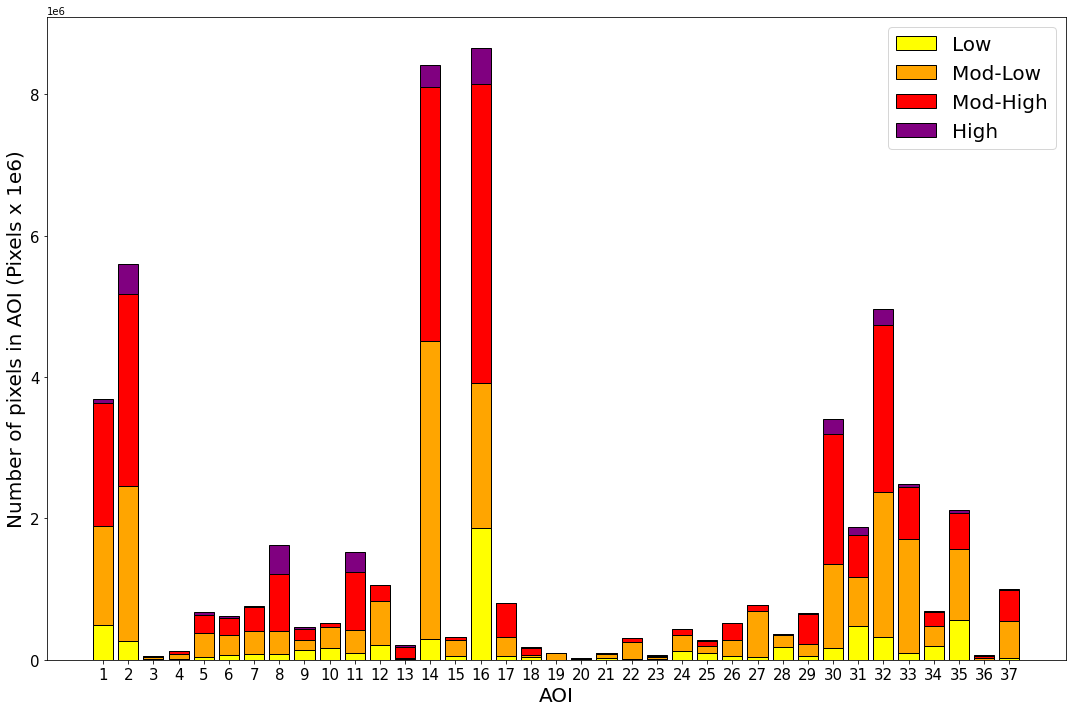

In [102]:
# All AOIs pixel distribution per burn severity
plt.figure(figsize=[15,10])

plt.bar(range(1,38), img_size_df.low, color='yellow', edgecolor='black')
plt.bar(range(1,38), img_size_df['low-med'], bottom=img_size_df.low, color='orange', edgecolor='black')
plt.bar(range(1,38), img_size_df['med-high'], bottom=img_size_df.low+img_size_df['low-med'], color='red', edgecolor='black')
plt.bar(range(1,38), img_size_df.high, bottom=img_size_df.low+img_size_df['low-med']+img_size_df['med-high'], color='purple', edgecolor='black')
plt.xlabel("AOI", size = 20)
plt.xticks(range(1,38), size=15)
plt.yticks(size=15)
plt.ylabel("Number of pixels in AOI (Pixels x 1e6)", size = 20)
plt.legend(["Low", "Mod-Low", "Mod-High", "High"], fontsize = 20)
plt.show()

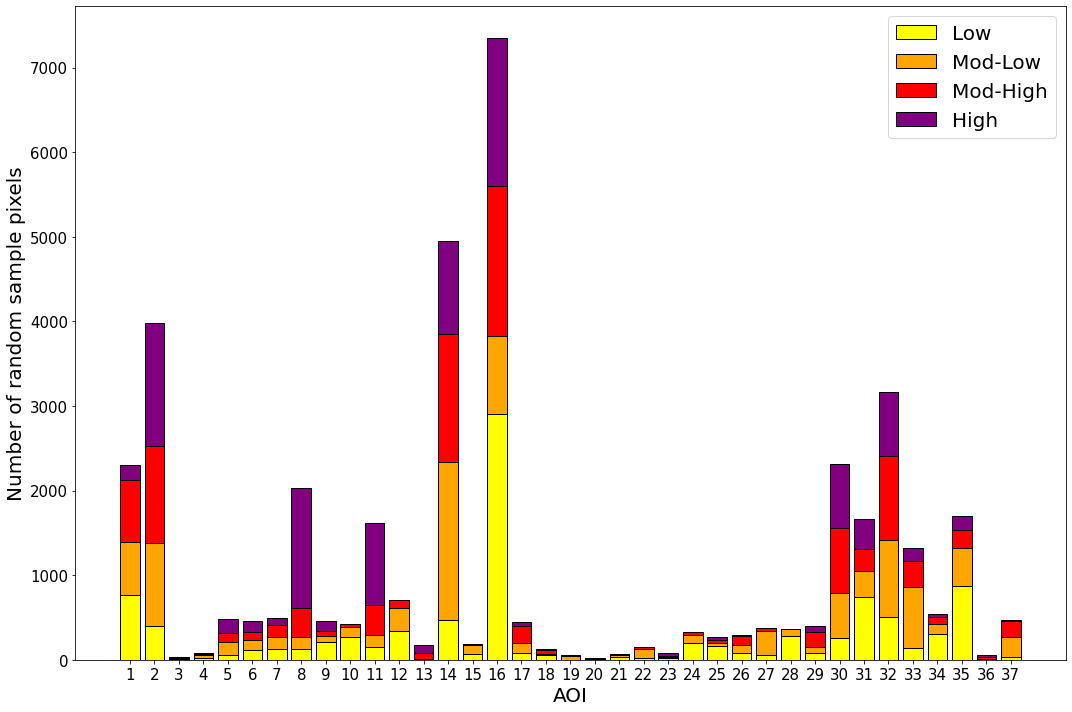

In [103]:
# Random sampling distribution
plt.figure(figsize=[15,10])

plt.bar(range(1,38), df1.low, color='yellow', edgecolor='black')
plt.bar(range(1,38), df1['low-med'], bottom=df1.low, color='orange', edgecolor='black')
plt.bar(range(1,38), df1['med-high'], bottom=df1.low+df1['low-med'], color='red', edgecolor='black')
plt.bar(range(1,38), df1.high, bottom=df1.low+df1['low-med']+df1['med-high'], color='purple', edgecolor='black')
plt.xlabel("AOI", size = 20)
plt.xticks(range(1,38), size=15)
plt.yticks(size=15)
plt.ylabel("Number of random sample pixels", size = 20)
plt.legend(["Low", "Mod-Low", "Mod-High", "High"], fontsize = 20)
plt.show()

### Visualize randomly sampled points and their geographic locations

In [104]:
import geopandas
gdf = geopandas.GeoDataFrame(training_dataset_gdb, 
                             geometry=geopandas.points_from_xy(training_dataset_gdb.Longitude, training_dataset_gdb.Latitude))

del training_dataset_gdb

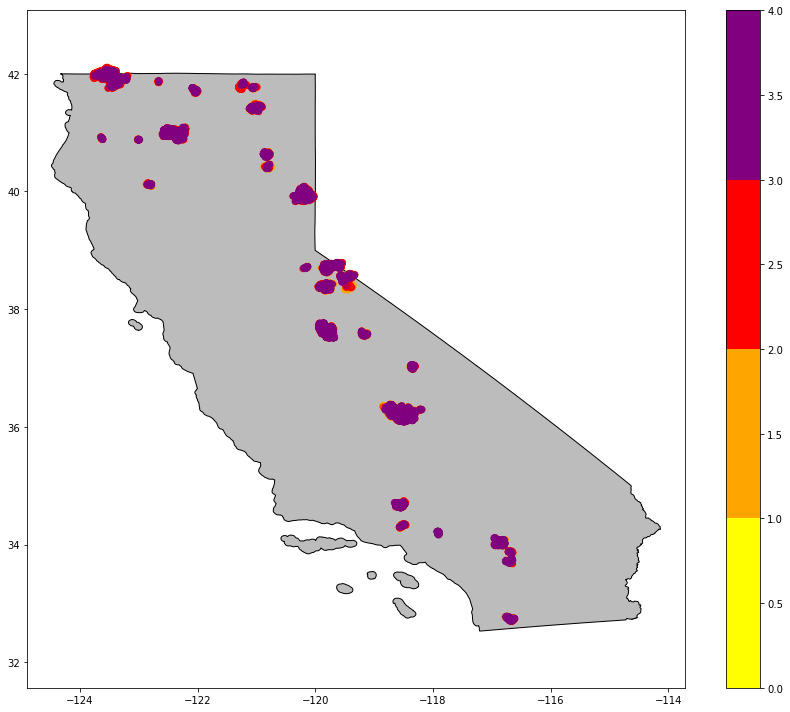

In [105]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

boundary = geopandas.read_file('/Users/minho/Desktop/CE263/Project/datasets/cali_shp')
boundary = boundary.to_crs(epsg=4326)
cmap = matplotlib.colors.ListedColormap(['yellow','orange','red','purple'])


# plt.scatter(gdf['Longitude'],gdf['Latitude'], cmap=cmap, alpha=0.3, s=5,
#             label=str(gdf['class']))
    
fig, ax = plt.subplots(figsize=(12, 10))
boundary.plot(ax=ax, color='#bcbcbc', edgecolor='black')
im = gdf.plot(ax=ax, column='class', k=5, vmin=0, vmax=4,cmap=cmap,alpha=0.5)
#          legend=True, legend_kwds = {"fmt": "{:.d}", "ticks":[0.5,1.5,2.5,3.5]})

cbar = plt.cm.ScalarMappable(cmap=cmap)
fig.colorbar(cbar, ax=ax)
# fig.colorbar(cbar, ax=ax, ticks=['Low','Mod-Low','Mod-High,','High'])
cbar.set_clim(0, 4)

# ax.axis('off')
plt.axis('equal')
plt.show()

In [106]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

cr = classification_report(y_test, y_pred)
print(cr)

Accuracy: 0.5912107174158007
              precision    recall  f1-score   support

           1       0.63      0.65      0.64      2039
           2       0.52      0.48      0.50      1906
           3       0.51      0.49      0.50      1973
           4       0.67      0.74      0.71      2069

    accuracy                           0.59      7987
   macro avg       0.58      0.59      0.59      7987
weighted avg       0.59      0.59      0.59      7987



In [107]:
# For methods 1-4, use 10 features 
feature_names = ['Blue','Green','Red','NIR','NDVI','SAVI','DEM','Slope','Aspect','LULC']

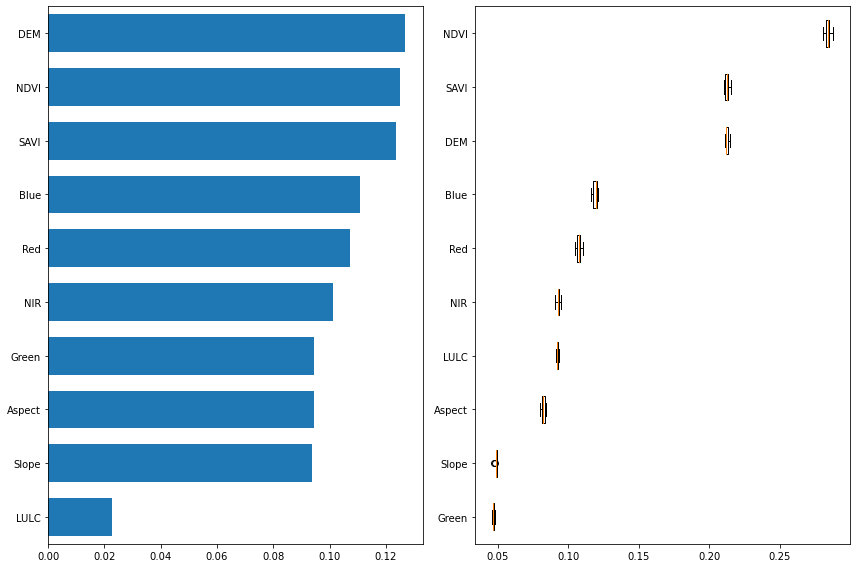

In [108]:
# Combination of MDI and permutation importance (Vertical graphs)

result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels([feature_names[i] for i in tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=[feature_names[i] for i in perm_sorted_idx],
)
fig.tight_layout()
plt.show()

## Set of all machine learning algorithms

In [109]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

clf_list = {
    'mlp': MLPClassifier(random_state=random_state, max_iter=1000),
    'gnb': GaussianNB(),
    'ada': AdaBoostClassifier(random_state=random_state),
    'gbc': GradientBoostingClassifier(random_state=random_state),
    'rf':  RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=random_state)
}
clf_df = []


def ml_classify(clf, clf_name):

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    print(key, "accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    cr = classification_report(y_test, y_pred, output_dict = True)
    df = pd.DataFrame(cr).transpose()
    
    return df


for key, classifier in clf_list.items():
    cr = ml_classify(classifier, key)
#     clf_df.append(key)
    clf_df.append(cr)

mlp accuracy: 0.5601602604231877
gnb accuracy: 0.4114185551521222
ada accuracy: 0.4698885689245023
gbc accuracy: 0.531864279454113
rf accuracy: 0.593965193439339


In [46]:
# Save files to folder

# clf_df[0].to_csv ('mlp_fixed.csv', index = False, header=True)
# clf_df[1].to_csv ('gnb_fixed.csv', index = False, header=True)
# clf_df[2].to_csv ('ada_fixed.csv', index = False, header=True)
# clf_df[3].to_csv ('gbc_fixed.csv', index = False, header=True)
# clf_df[4].to_csv ('rf_fixed.csv', index = False, header=True)

## Method 2 : Fixed random sampling

In [47]:
# Set AOI sample counts
df1 = burn_sev_df.round(0).astype(int)
fixed_sample_num = 300

# Set empty placeholders for training dataset
low_train = pd.DataFrame(columns = ['c1','c2','features'])
mlow_train = pd.DataFrame(columns = ['c1','c2','features'])
mhigh_train = pd.DataFrame(columns = ['c1','c2','features'])
high_train = pd.DataFrame(columns = ['c1','c2','features'])

In [48]:
# Method 2 : Fixed number of random samples

df1['low']= fixed_sample_num
df1['low-med'] = fixed_sample_num
df1['med-high'] = fixed_sample_num
df1['high'] = fixed_sample_num

In [49]:
# Method 2 : Fixed random sampling
for i in range(len(df1)): # df1 = Dataframe with burn severity AOIs
   
    img_stack, img_stack_meta = input_data(method=1)
    
    # Find required number of samples for each burn severity class
    aoi_t, aoi_low, aoi_mlow, aoi_mhigh, aoi_high = read_aoi(aoi_train[i])

    def random_sample(sample_dataset, sev_dataset, clss, sev_num):
        # Number of samples to be selected for random sampling
        sample_count = sample_dataset[clss][i]

        if np.nanmax(sev_dataset) > 0:
            # Random sampling for each burn severity class
            sev_df = aoi_sampling(img_stack, sev_dataset, sev_num, sample_count, random_state, img_stack_meta)
        else:
            sev_df = 0
        return sev_df

    # Extract random samples from each burn severity class
    low_df = random_sample(df1, aoi_low, 'low', 1)
    mlow_df = random_sample(df1, aoi_mlow, 'low-med', 2)
    mhigh_df = random_sample(df1, aoi_mhigh, 'med-high', 3)
    high_df = random_sample(df1, aoi_high, 'high', 4)
    
    # Add to training datasets
    if np.nanmax(aoi_low) > 0:
        low_train=low_train.append(low_df)
    if np.nanmax(aoi_mlow) > 0:
        mlow_train=mlow_train.append(mlow_df)
    if np.nanmax(aoi_mhigh) > 0:
        mhigh_train=mhigh_train.append(mhigh_df)
    if np.nanmax(aoi_high) > 0:
        high_train=high_train.append(high_df)


In [50]:
print("Low: ", len(low_train))
print("Low-Med: ", len(mlow_train))
print("Med-High: ", len(mhigh_train))
print("High: ", len(high_train))

del aoi_low, aoi_mlow, aoi_mhigh, aoi_high, img_stack 
del low_df, mlow_df, mhigh_df, high_df
# del aoi, aoi_t

Low:  10800
Low-Med:  11100
Med-High:  11100
High:  9300


In [51]:
def random_drop(sev_dataset,lowest_dataset):
    remove_n = len(sev_dataset) - len(lowest_dataset)
    
    sev_df = sev_dataset.reset_index(inplace=False, drop=True)
    df_dropped = sev_df.drop(sev_df.sample(n=remove_n).index)
    
    return df_dropped

In [52]:
low_train = random_drop(low_train, high_train)
mlow_train = random_drop(mlow_train, high_train)
mhigh_train = random_drop(mhigh_train, high_train)

In [53]:
print("Low: ", len(low_train))
print("Low-Med: ", len(mlow_train))
print("Med-High: ", len(mhigh_train))
print("High: ", len(high_train))

# del aoi_low, aoi_mlow, aoi_mhigh, aoi_high, img_stack 
# del low_df, mlow_df, mhigh_df, high_df
# del aoi, aoi_t

Low:  9300
Low-Med:  9300
Med-High:  9300
High:  9300


In [54]:
def create_datasets(train_set, sev):
#     train_dataset = train_set.reset_index(inplace=False, drop=True)
    train_dataset = pd.DataFrame(train_set["features"].to_list(), columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])

    gt_dataset = np.full((train_dataset.shape[0], 1), sev)
    
    return train_dataset, gt_dataset

low_train, low_gt = create_datasets(low_train, 1)
mlow_train, mlow_gt = create_datasets(mlow_train, 2)
mhigh_train, mhigh_gt = create_datasets(mhigh_train, 3)
high_train, high_gt = create_datasets(high_train, 4)

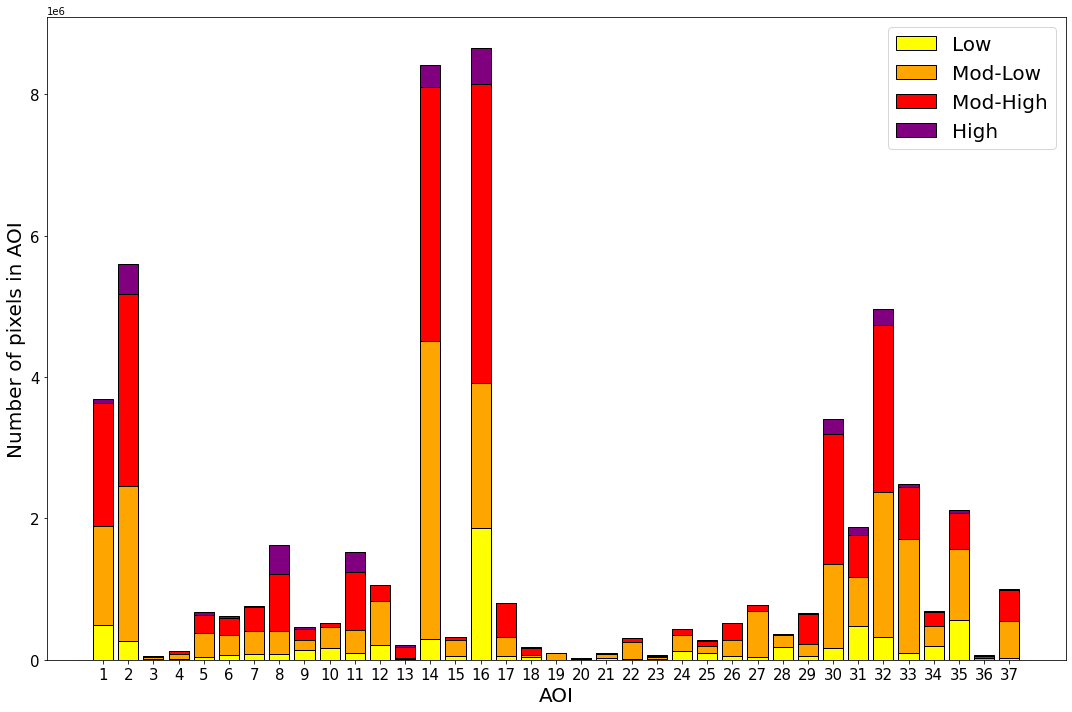

In [55]:
# All AOIs pixel distribution per burn severity
plt.figure(figsize=[15,10])

plt.bar(range(1,38), img_size_df.low, color='yellow', edgecolor='black')
plt.bar(range(1,38), img_size_df['low-med'], bottom=img_size_df.low, color='orange', edgecolor='black')
plt.bar(range(1,38), img_size_df['med-high'], bottom=img_size_df.low+img_size_df['low-med'], color='red', edgecolor='black')
plt.bar(range(1,38), img_size_df.high, bottom=img_size_df.low+img_size_df['low-med']+img_size_df['med-high'], color='purple', edgecolor='black')
plt.xlabel("AOI", size = 20)
plt.xticks(range(1,38), size=15)
plt.yticks(size=15)
plt.ylabel("Number of pixels in AOI", size = 20)
plt.legend(["Low", "Mod-Low", "Mod-High", "High"], fontsize = 20)
plt.show()

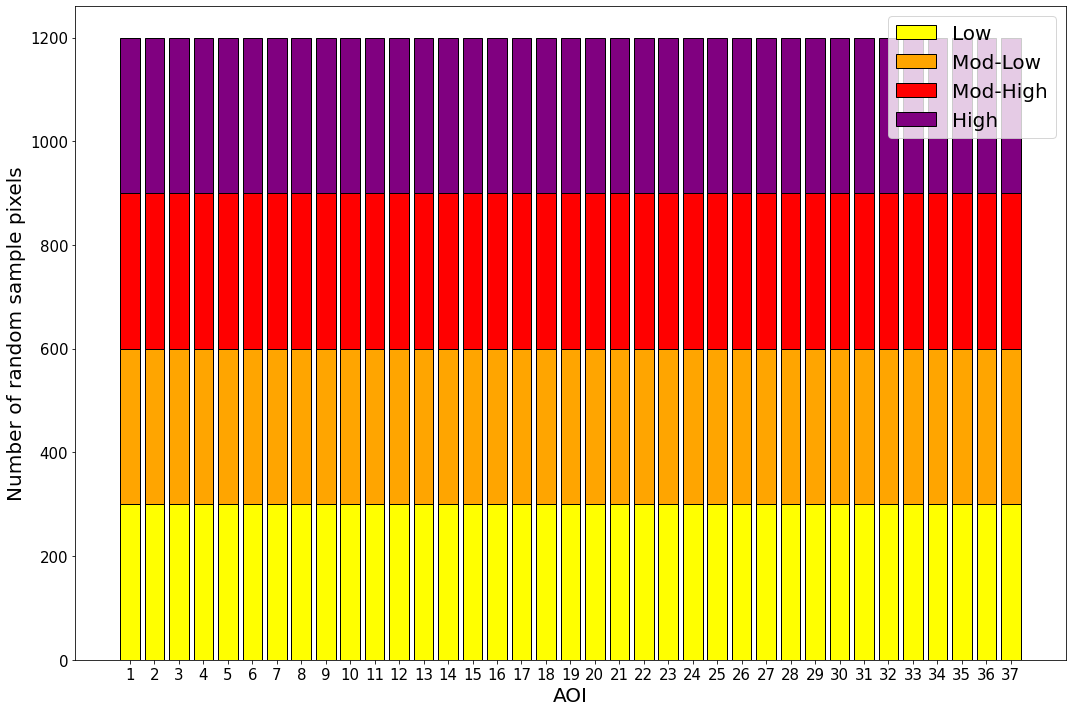

In [56]:
# Random sampling distribution
plt.figure(figsize=[15,10])

plt.bar(range(1,38), df1.low, color='yellow', edgecolor='black')
plt.bar(range(1,38), df1['low-med'], bottom=df1.low, color='orange', edgecolor='black')
plt.bar(range(1,38), df1['med-high'], bottom=df1.low+df1['low-med'], color='red', edgecolor='black')
plt.bar(range(1,38), df1.high, bottom=df1.low+df1['low-med']+df1['med-high'], color='purple', edgecolor='black')
plt.xlabel("AOI", size = 20)
plt.xticks(range(1,38), size=15)
plt.yticks(size=15)
plt.ylabel("Number of random sample pixels", size = 20)
plt.legend(["Low", "Mod-Low", "Mod-High", "High"], fontsize = 20)
plt.show()

In [57]:
training_dataset = np.vstack((low_train, mlow_train, mhigh_train, high_train))
gt_dataset = np.vstack((low_gt, mlow_gt, mhigh_gt, high_gt))

In [58]:
# Holdout sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_dataset, gt_dataset, test_size=0.2, random_state=random_state)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

print("Training dataset size: ", len(X_train))
print("Test dataset size: ", len(X_test))

Training dataset size:  29760
Test dataset size:  7440


In [59]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

cr = classification_report(y_test, y_pred)
print(cr)

Accuracy: 0.5766129032258065
              precision    recall  f1-score   support

           1       0.61      0.59      0.60      1928
           2       0.47      0.43      0.45      1854
           3       0.52      0.52      0.52      1834
           4       0.68      0.78      0.72      1824

    accuracy                           0.58      7440
   macro avg       0.57      0.58      0.57      7440
weighted avg       0.57      0.58      0.57      7440



In [62]:
# For methods 1-4, use 10 features 
feature_names = ['Blue','Green','Red','NIR','NDVI','SAVI','DEM','Slope','Aspect','LULC']

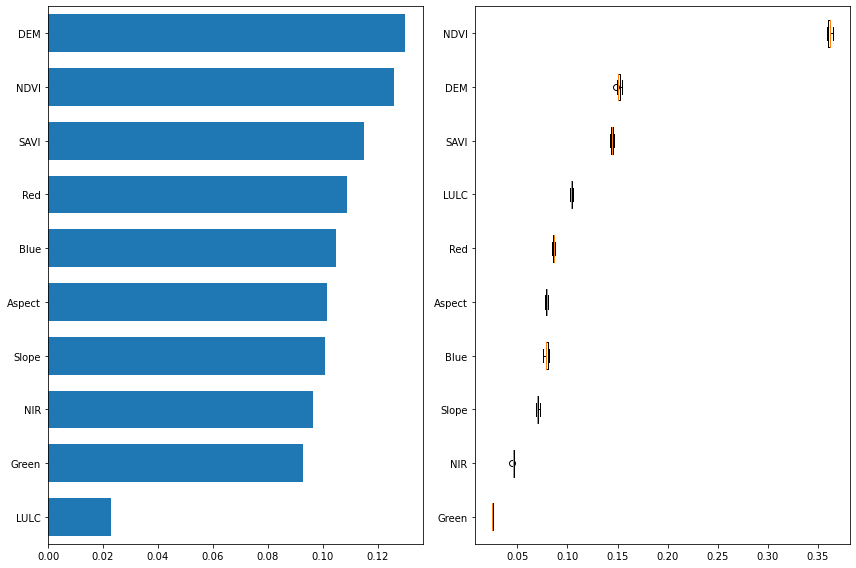

In [66]:
# Combination of MDI and permutation importance (Vertical graphs)

result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels([feature_names[i] for i in tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=[feature_names[i] for i in perm_sorted_idx],
)
fig.tight_layout()
plt.show()

## Set of all machine learning algorithms

In [67]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

clf_list = {
    'mlp': MLPClassifier(random_state=random_state, max_iter=1000),
    'gnb': GaussianNB(),
    'ada': AdaBoostClassifier(random_state=random_state),
    'gbc': GradientBoostingClassifier(random_state=random_state),
    'rf':  RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=random_state)
}
clf_df = []


def ml_classify(clf, clf_name):

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    print(key, "accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    cr = classification_report(y_test, y_pred, output_dict = True)
    df = pd.DataFrame(cr).transpose()
    
    return df


for key, classifier in clf_list.items():
    cr = ml_classify(classifier, key)
#     clf_df.append(key)
    clf_df.append(cr)

mlp accuracy: 0.4922043010752688
gnb accuracy: 0.3856182795698925
ada accuracy: 0.4352150537634409
gbc accuracy: 0.49489247311827955
rf accuracy: 0.5721774193548387


In [68]:
# Save files to folder

# clf_df[0].to_csv ('mlp_fixed.csv', index = False, header=True)
# clf_df[1].to_csv ('gnb_fixed.csv', index = False, header=True)
# clf_df[2].to_csv ('ada_fixed.csv', index = False, header=True)
# clf_df[3].to_csv ('gbc_fixed.csv', index = False, header=True)
# clf_df[4].to_csv ('rf_fixed.csv', index = False, header=True)

## Method 3 (Chronological order for data split)
Data is sorted in chronological order and the train/test split is divided into 2018~2020 train and 2021 test
- 2021 : 0-9
- 2020 : 10-27
- 2019 : 28-37
- 2018 : 39-50

In [69]:
burn_sev_list_21 = sorted(burn_sev_list)[0:6]
burn_sev_list_20 = sorted(burn_sev_list)[6:17]
burn_sev_list_19 = sorted(burn_sev_list)[17:27]
burn_sev_list_18 = sorted(burn_sev_list)[27:]

In [70]:
burn_sev_list_test = sorted(burn_sev_list)[0:17]
burn_sev_list_train = sorted(burn_sev_list)[17:]

### Method 3 (Fixed sampling)

In [71]:
# Set AOI sample counts
df_full = burn_sev_df.round(0).astype(int)
ind = 6

# Test dataset - 2021
# Train dataset - 2020 ~ 2018

df_test = df_full[0:ind].reset_index(inplace=False)
df_train = df_full[ind:].reset_index(inplace=False)

aoi_train_set = aoi_train[ind:]
aoi_test_set = aoi_train[:ind]

In [72]:
# Method 3

def input_data_m3(method, index):
    
    # Open input datasets for each AOI
    img_t, meta_img = open_multiband(img_train[index])
    dem_t, meta_dem = open_data(dem_train[index])
    slope_t, meta_slope = open_data(slope_train[index])
    lulc_t, meta_lulc = open_data(lulc_train[index])

    ndvi_t = (img_t[:,:,3]/65535 - img_t[:,:,2]/65535) / (img_t[:,:,3]/65535 + img_t[:,:,2]/65535)
    savi=((img_t[:,:,3]/65535 - img_t[:,:,2]/65535)/(img_t[:,:,3]/65535 +img_t[:,:,2]/65535 +0.5))*(1+0.5)
    
    ndvi_t[ndvi_t < 0.2] = 0
    
    lulc_t[lulc_t == 10] = 1
    lulc_t[lulc_t == 20] = 2
    lulc_t[lulc_t == 30] = 3
    lulc_t[lulc_t == 40] = 4 
    lulc_t[lulc_t == 95]= 5
    
    x, y = np.gradient(dem_t)
    aspect = np.arctan2(-x, y)
    del x,y

    img_stack = np.dstack((minmax(img_t), 
                           minmax(ndvi_t), 
                           minmax(savi), 
                           minmax(dem_t), 
                           minmax(slope_t), 
                           aspect, 
                           lulc_t))    
    
    if method == 1:
        return img_stack, meta_img
    
    if method == 4:
        # Zero-padding for input datasets (for patch-based sampling)
        pad_width = int(patch_size/2), int(patch_size/2)
        img_padded = np.pad(img_stack, pad_width=[pad_width,pad_width,(0,0)], mode='constant')
        return img_padded
    
def method3(df, aoi_list):
    
    # Set empty placeholders for training dataset
    low_train = pd.DataFrame(columns = ['c1','c2','features'])
    mlow_train = pd.DataFrame(columns = ['c1','c2','features'])
    mhigh_train = pd.DataFrame(columns = ['c1','c2','features'])
    high_train = pd.DataFrame(columns = ['c1','c2','features'])

    # Random sampling
    for i in range(len(df)): # df1 = Dataframe with burn severity AOIs        
        img_stack, img_stack_meta = input_data_m3(1, df['index'][i])
        
        # Find required number of samples for each burn severity class
        aoi_t, aoi_low, aoi_mlow, aoi_mhigh, aoi_high = read_aoi(aoi_list[i])
        
        def random_sample(sample_dataset, sev_dataset, clss, sev_num):
            # Number of samples to be selected for random sampling
            sample_count = sample_dataset[clss][i]
            
            # Random sampling for each burn severity class
            sev_df = aoi_sampling(img_stack, sev_dataset, sev_num, sample_count, random_state, img_stack_meta)
            return sev_df

        # Extract random samples from each burn severity class
        low_df = random_sample(df, aoi_low, 'low', 1)
        mlow_df = random_sample(df, aoi_mlow, 'low-med', 2)
        mhigh_df = random_sample(df, aoi_mhigh, 'med-high', 3)
        high_df = random_sample(df, aoi_high, 'high', 4)

        # Add to training datasets
        low_train=low_train.append(low_df)
        mlow_train=mlow_train.append(mlow_df)
        mhigh_train=mhigh_train.append(mhigh_df)
        high_train=high_train.append(high_df)

    return low_train, mlow_train, mhigh_train, high_train


def aoi_sampling(img_stack, aoi_class, sev_num, sample_count, random_state, img_stack_meta):

    # Set mask based on burn severity class: Low = 1 / Med-Low = 2 / Med-High = 3 / High = 4
    aoi_mask = np.where(aoi_class == sev_num)

    # Create AOI df to input random sampling data
    aoi_df = pd.DataFrame()
    aoi_df['c1'] = aoi_mask[0]
    aoi_df['c2'] = aoi_mask[1]
    
    sampled_aois = aoi_df.sample(n=sample_count, replace=True, random_state=random_state) # Randomly sampled AOI coordinates
        
    # Empty placers for sampled features
    sampled_aois['features'] = np.zeros(sampled_aois.shape[0])
    sampled_features = []
    lons, lats = [],[]
    
    # Extract features (as points) from stacked images using randomly sampled points
    for j in sampled_aois.index:
                
        img_stack_train = img_stack[aoi_df['c1'][j], aoi_df['c2'][j],:] 
        sampled_features.append(img_stack_train)
        
        lon,lat = rasterio.transform.xy(img_stack_meta['transform'], aoi_df['c1'][j], aoi_df['c2'][j])
        lons.append(lon)
        lats.append(lat)
        
    # Resulting samples as a dataframe with features in a list format
    sampled_aois['longitude'] = lons
    sampled_aois['latitude'] = lats
    sampled_aois['features'] = sampled_features 
    
    return sampled_aois

In [73]:
low_train, mlow_train, mhigh_train, high_train = method3(df_train, aoi_train_set)
low_test, mlow_test, mhigh_test, high_test = method3(df_test, aoi_test_set)

In [74]:
def create_datasets(train_set, sev):
    train = train_set.reset_index(inplace=False, drop=True)
    train_dataset = pd.DataFrame(train["features"].to_list(), columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])

    gt_dataset = np.full((train_dataset.shape[0], 1), sev)
    
    return train_dataset, gt_dataset

low_train, low_gt = create_datasets(low_train, 1)
mlow_train, mlow_gt = create_datasets(mlow_train, 2)
mhigh_train, mhigh_gt = create_datasets(mhigh_train, 3)
high_train, high_gt = create_datasets(high_train, 4)

low_test, low_gt_test = create_datasets(low_test, 1)
mlow_test, mlow_gt_test = create_datasets(mlow_test, 2)
mhigh_test, mhigh_gt_test = create_datasets(mhigh_test, 3)
high_test, high_gt_test = create_datasets(high_test, 4)


In [75]:
X_train = np.vstack((low_train, mlow_train, mhigh_train, high_train))
y_train = np.vstack((low_gt, mlow_gt, mhigh_gt, high_gt))

X_test = np.vstack((low_test, mlow_test, mhigh_test, high_test))
y_test = np.vstack((low_gt_test, mlow_gt_test, mhigh_gt_test, high_gt_test))


print("Training dataset size: ", len(X_train))
print("Test dataset size: ", len(X_test))

Training dataset size:  32610
Test dataset size:  7325


In [76]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

cr = classification_report(y_test, y_pred)
print(cr)

Accuracy: 0.2045051194539249
              precision    recall  f1-score   support

           1       0.18      0.85      0.30      1364
           2       0.27      0.11      0.15      1922
           3       0.30      0.01      0.02      2106
           4       0.59      0.06      0.11      1933

    accuracy                           0.20      7325
   macro avg       0.34      0.26      0.15      7325
weighted avg       0.35      0.20      0.13      7325



In [77]:
# For methods 1-4, use 10 features 
feature_names = ['Blue','Green','Red','NIR','NDVI','SAVI','DEM','Slope','Aspect','LULC']

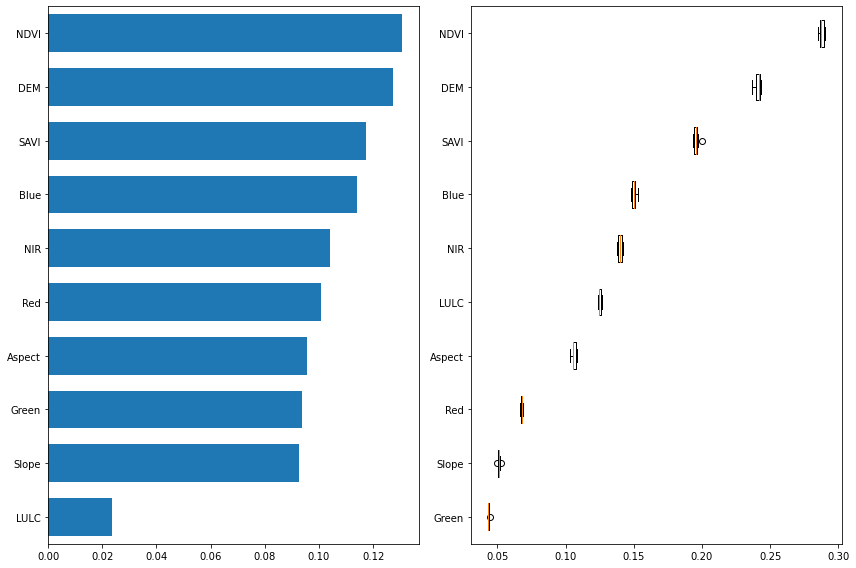

In [78]:
# Combination of MDI and permutation importance (Vertical graphs)

result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels([feature_names[i] for i in tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=[feature_names[i] for i in perm_sorted_idx],
)
fig.tight_layout()
plt.show()

## Set of all machine learning algorithms

In [79]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

clf_list = {
    'mlp': MLPClassifier(random_state=random_state, max_iter=1000),
    'gnb': GaussianNB(),
    'ada': AdaBoostClassifier(random_state=random_state),
    'gbc': GradientBoostingClassifier(random_state=random_state),
    'rf':  RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=random_state)
}
clf_df = []


def ml_classify(clf, clf_name):

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    print(key, "accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    cr = classification_report(y_test, y_pred, output_dict = True)
    df = pd.DataFrame(cr).transpose()
    
    return df


for key, classifier in clf_list.items():
    cr = ml_classify(classifier, key)
#     clf_df.append(key)
    clf_df.append(cr)

mlp accuracy: 0.21242320819112628
gnb accuracy: 0.4371331058020478
ada accuracy: 0.24013651877133105
gbc accuracy: 0.2143344709897611
rf accuracy: 0.2


In [80]:
# Save files to folder

# clf_df[0].to_csv ('mlp_fixed.csv', index = False, header=True)
# clf_df[1].to_csv ('gnb_fixed.csv', index = False, header=True)
# clf_df[2].to_csv ('ada_fixed.csv', index = False, header=True)
# clf_df[3].to_csv ('gbc_fixed.csv', index = False, header=True)
# clf_df[4].to_csv ('rf_fixed.csv', index = False, header=True)

### Method 3 (Fixed sampling)

In [81]:
# Set AOI sample counts
df_full = burn_sev_df.round(0).astype(int)
ind = 17

# Test dataset - 2021
# Train dataset - 2020 ~ 2018
df_test = df_full[0:ind].reset_index(inplace=False)
df_train = df_full[ind:].reset_index(inplace=False)

aoi_test_set = aoi_train[:ind]
aoi_train_set = aoi_train[ind:]

In [82]:
# Method 2 : Fixed number of random samples

df_test['low'],df_test['low-med'],df_test['med-high'],df_test['high'], = 300, 300, 300, 300
df_train['low'],df_train['low-med'],df_train['med-high'],df_train['high'], = 300, 300, 300, 300

In [83]:
def method3_fixed(df, aoi_list):
        
    # Set empty placeholders for training dataset
    low_train = pd.DataFrame(columns = ['c1','c2','features'])
    mlow_train = pd.DataFrame(columns = ['c1','c2','features'])
    mhigh_train = pd.DataFrame(columns = ['c1','c2','features'])
    high_train = pd.DataFrame(columns = ['c1','c2','features'])
    
    # Random sampling
    for i in range(len(df)): # df1 = Dataframe with burn severity AOIs
#         print("Check:",i ,"with ", df['index'][i])

        img_stack, img_stack_meta = input_data_m3(1, df['index'][i])

        # Find required number of samples for each burn severity class
        aoi_t, aoi_low, aoi_mlow, aoi_mhigh, aoi_high = read_aoi(aoi_list[i])

#         print("Img :", img_stack.shape)
#         print("AOI :", aoi_low.shape)

        def random_sample(sample_dataset, sev_dataset, clss, sev_num):
            # Number of samples to be selected for random sampling
            sample_count = sample_dataset[clss][i]

            if np.nanmax(sev_dataset) > 0:
                # Random sampling for each burn severity class
                sev_df = aoi_sampling(img_stack, sev_dataset, sev_num, sample_count, random_state,img_stack_meta)
            else:
                sev_df = 0

            return sev_df

        # Extract random samples from each burn severity class
        low_df = random_sample(df, aoi_low, 'low', 1)
        mlow_df = random_sample(df, aoi_mlow, 'low-med', 2)
        mhigh_df = random_sample(df, aoi_mhigh, 'med-high', 3)
        high_df = random_sample(df, aoi_high, 'high', 4)

        # Add to training datasets
        if np.nanmax(aoi_low) > 0:
            low_train=low_train.append(low_df)
        if np.nanmax(aoi_mlow) > 0:
            mlow_train=mlow_train.append(mlow_df)
        if np.nanmax(aoi_mhigh) > 0:
            mhigh_train=mhigh_train.append(mhigh_df)
        if np.nanmax(aoi_high) > 0:
            high_train=high_train.append(high_df)
            
    return low_train, mlow_train, mhigh_train, high_train

In [84]:
low_train, mlow_train, mhigh_train, high_train = method3_fixed(df_train, aoi_train_set)
low_test, mlow_test, mhigh_test, high_test = method3_fixed(df_test, aoi_test_set)

In [85]:
def random_drop(sev_dataset,lowest_dataset):
    remove_n = len(sev_dataset) - len(lowest_dataset)
    
    sev_df = sev_dataset.reset_index(inplace=False, drop=True)
    df_dropped = sev_df.drop(sev_df.sample(n=remove_n).index)
    
    return df_dropped

In [86]:
low_train = random_drop(low_train, high_train)
mlow_train = random_drop(mlow_train, high_train)
mhigh_train = random_drop(mhigh_train, high_train)

low_test = random_drop(low_test, high_test)
mlow_test = random_drop(mlow_test, high_test)
mhigh_test = random_drop(mhigh_test, high_test)

In [87]:
def create_datasets(train_set, sev):
    train = train_set.reset_index(inplace=False, drop=True)
    train_dataset = pd.DataFrame(train["features"].to_list(), columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
#     train_dataset['latitude'] = train['latitude']
#     train_dataset['longitude'] = train['longitude']

    gt_dataset = np.full((train_dataset.shape[0], 1), sev)
    
    return train_dataset, gt_dataset

low_train, low_gt = create_datasets(low_train, 1)
mlow_train, mlow_gt = create_datasets(mlow_train, 2)
mhigh_train, mhigh_gt = create_datasets(mhigh_train, 3)
high_train, high_gt = create_datasets(high_train, 4)

low_test, low_gt_test = create_datasets(low_test, 1)
mlow_test, mlow_gt_test = create_datasets(mlow_test, 2)
mhigh_test, mhigh_gt_test = create_datasets(mhigh_test, 3)
high_test, high_gt_test = create_datasets(high_test, 4)


In [88]:
X_train = np.vstack((low_train, mlow_train, mhigh_train, high_train))
y_train = np.vstack((low_gt, mlow_gt, mhigh_gt, high_gt))

X_test = np.vstack((low_test, mlow_test, mhigh_test, high_test))
y_test = np.vstack((low_gt_test, mlow_gt_test, mhigh_gt_test, high_gt_test))


print("Training dataset size: ", len(X_train))
print("Test dataset size: ", len(X_test))

Training dataset size:  19200
Test dataset size:  18000


In [89]:
from sklearn.utils import shuffle
X_train,y_train = shuffle(X_train, y_train)
X_test,y_test = shuffle(X_test, y_test)

In [90]:
# Holdout sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # 0.25 x 0.8 = 0.2

print("Training dataset size: ", len(X_train))
print("Test dataset size: ", len(X_test))

Training dataset size:  15360
Test dataset size:  18000


In [91]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

cr = classification_report(y_test, y_pred)
print(cr)

Accuracy: 0.32822222222222225
              precision    recall  f1-score   support

           1       0.33      0.56      0.41      4500
           2       0.25      0.21      0.23      4500
           3       0.27      0.17      0.21      4500
           4       0.44      0.38      0.41      4500

    accuracy                           0.33     18000
   macro avg       0.32      0.33      0.31     18000
weighted avg       0.32      0.33      0.31     18000



In [92]:
# For methods 1-4, use 10 features 
feature_names = ['Blue','Green','Red','NIR','NDVI','SAVI','DEM','Slope','Aspect','LULC','class']

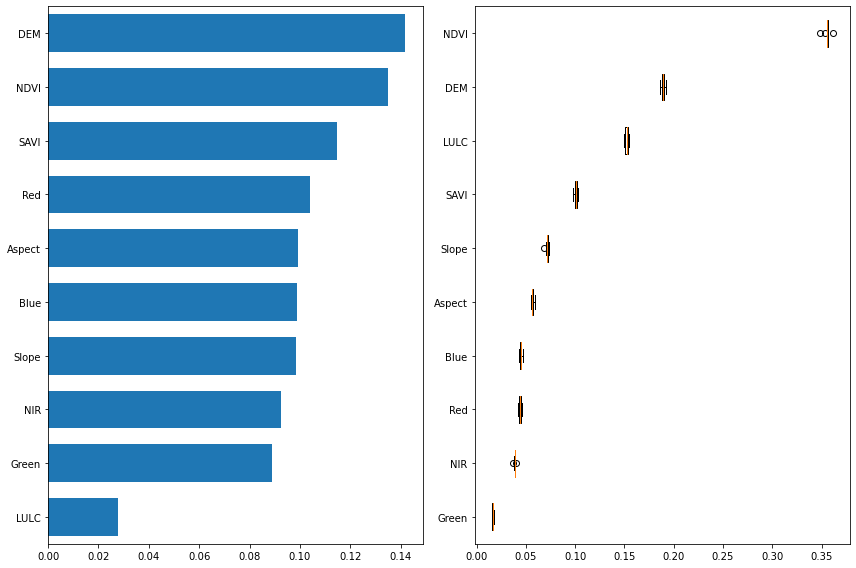

In [93]:
# Combination of MDI and permutation importance (Vertical graphs)

result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels([feature_names[i] for i in tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=[feature_names[i] for i in perm_sorted_idx],
)
fig.tight_layout()
plt.show()

## Set of all machine learning algorithms

In [94]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

clf_list = {
    'mlp': MLPClassifier(random_state=random_state, max_iter=1000),
    'gnb': GaussianNB(),
    'ada': AdaBoostClassifier(random_state=random_state),
    'gbc': GradientBoostingClassifier(random_state=random_state),
    'rf':  RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=random_state)
}
clf_df = []


def ml_classify(clf, clf_name):

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    print(key, "accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    cr = classification_report(y_test, y_pred, output_dict = True)
    df = pd.DataFrame(cr).transpose()
    
    return df


for key, classifier in clf_list.items():
    cr = ml_classify(classifier, key)
#     clf_df.append(key)
    clf_df.append(cr)

mlp accuracy: 0.3477777777777778
gnb accuracy: 0.36877777777777776
ada accuracy: 0.3708888888888889
gbc accuracy: 0.3555
rf accuracy: 0.33161111111111113


In [ ]:
# Save files to folder

# clf_df[0].to_csv ('mlp_fixed.csv', index = False, header=True)
# clf_df[1].to_csv ('gnb_fixed.csv', index = False, header=True)
# clf_df[2].to_csv ('ada_fixed.csv', index = False, header=True)
# clf_df[3].to_csv ('gbc_fixed.csv', index = False, header=True)
# clf_df[4].to_csv ('rf_fixed.csv', index = False, header=True)

# Method 4 (Patches for Tensors) ** FOR DEEP LEARNING

In [ ]:
# Method 4 : Patch based sampling
patch_size = 10

for i in range(len(df1)): # df1 = Dataframe with burn severity AOIs
    
    img_padded = input_data(method=4)

    # Find required number of samples for each burn severity class
    aoi_t, aoi_low, aoi_mlow, aoi_mhigh, aoi_high = read_aoi(aoi_train[i])

    def random_sample(sample_dataset, sev_dataset, clss, sev_num):
        # Number of samples to be selected for random sampling
        sample_count = sample_dataset[clss][i]
        # Random sampling for each burn severity class
        sev_df = patch_sampling(img_padded, sev_dataset, sev_num, sample_count, patch_size, random_state)
        return sev_df

    # Extract random samples from each burn severity class
    low_df = random_sample(df1, aoi_low, 'low', 1)
    mlow_df = random_sample(df1, aoi_mlow, 'low-med', 2)
    mhigh_df = random_sample(df1, aoi_mhigh, 'med-high', 3)
    high_df = random_sample(df1, aoi_high, 'high', 4)
        
    # Add to training datasets
    low_train=low_train.append(low_df)
    mlow_train=mlow_train.append(mlow_df)
    mhigh_train=mhigh_train.append(mhigh_df)
    high_train=high_train.append(high_df)



In [ ]:
t1 = np.stack((low_train.features))
t2 = np.stack((mlow_train.features))
t3 = np.stack((mhigh_train.features))
t4 = np.stack((high_train.features))
training_dataset = np.vstack((t1,t2,t3,t4))

def create_gt(train_set, sev):
    gt_dataset = np.full((train_set.shape[0], 1), sev)
    return gt_dataset

low_gt = create_gt(low_train, 1)
mlow_gt = create_gt(mlow_train, 2)
mhigh_gt = create_gt(mhigh_train, 3)
high_gt = create_gt(high_train, 4)
gt_dataset = np.vstack((low_gt, mlow_gt, mhigh_gt, high_gt))

del t1, t2, t3, t4
del aoi_low, aoi_mlow, aoi_mhigh, aoi_high, img_padded, img, img_stack 
del img_t, slope_t, ndvi_t, dem_t, low_df, mlow_df, mhigh_df, high_df
del meta_img, meta_slope, meta_dem, aoi, aoi_t

In [53]:
# Holdout sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train
                                                    , test_size=0.2, random_state=random_state)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

print("Training dataset size: ", len(X_train))
print("Test dataset size: ", len(X_test))
# print("Validation dataset size: ", len(X_val))


Training dataset size:  4688
Test dataset size:  1172


# Part 2: Clustering

## KMeans

In [110]:
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

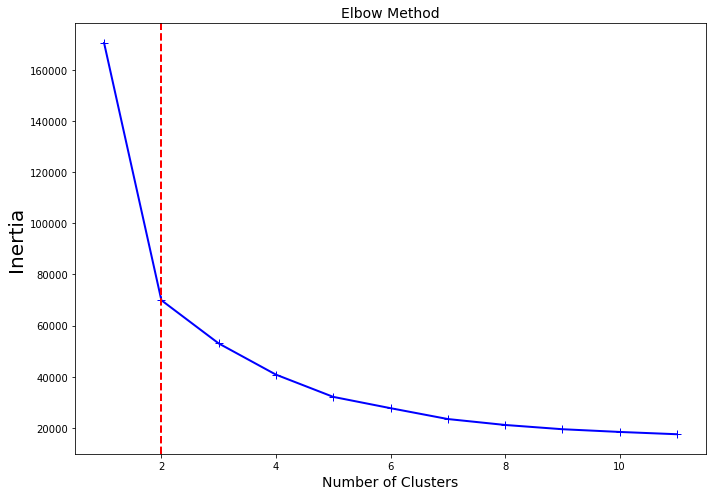

In [111]:
wss = [] # Inertia

K=range(1,12)

for k in K:
    kmeans=cluster.KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(training_dataset)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})

# Using elbow method to select the correct number of clusters
_ = plt.figure(figsize = (10,7))
_ = plt.plot(range(1,12), wss, linewidth = 2, color = 'blue', marker='+', markersize = 8)
_ = plt.title('Elbow Method', fontsize = 14)
_ = plt.xlabel('Number of Clusters',fontsize = 14)
_ = plt.ylabel('Inertia',fontsize = 20)

n_clusters = 2

_ = plt.axvline(x = n_clusters, linewidth = 2, color = 'red', linestyle = '--')
_ = plt.show()

In [112]:
# Double-checking the correct number of clusters is chosen using silhouette scores
for i in range(2,13):
    labels=cluster.KMeans(n_clusters=i,init="k-means++",random_state=random_state).fit(training_dataset).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(training_dataset,labels,metric="euclidean",
                                         sample_size=1000,random_state=random_state)))

Silhouette score for k(clusters) = 2 is 0.4823241934043628
Silhouette score for k(clusters) = 3 is 0.4492529461991358
Silhouette score for k(clusters) = 4 is 0.3765766893625183
Silhouette score for k(clusters) = 5 is 0.3986893540935656
Silhouette score for k(clusters) = 6 is 0.39323412540683855
Silhouette score for k(clusters) = 7 is 0.3529492929393247
Silhouette score for k(clusters) = 8 is 0.33566916084165016
Silhouette score for k(clusters) = 9 is 0.3277227239268102
Silhouette score for k(clusters) = 10 is 0.2948308233688698
Silhouette score for k(clusters) = 11 is 0.3030159086600706
Silhouette score for k(clusters) = 12 is 0.31048370051366864


In [113]:
# Takes forever to run...
silhouette_score(training_dataset, kmeans.labels_)

0.29666568854816155

In [114]:
kmeans_per_k = [cluster.KMeans(n_clusters=k, random_state=42).fit(training_dataset) for k in range(1,10)]

silhouette_scores = [silhouette_score(training_dataset, model.labels_)
                    for model in kmeans_per_k[1:]]
silhouette_scores

[0.48804550562821314,
 0.4422290672591694,
 0.3727988458376778,
 0.4018846091690816,
 0.3900457300078448,
 0.35501257369203365,
 0.3291653086031794,
 0.31836832008436816]

In [115]:
kmeans_per_k

[KMeans(n_clusters=1, random_state=42),
 KMeans(n_clusters=2, random_state=42),
 KMeans(n_clusters=3, random_state=42),
 KMeans(n_clusters=4, random_state=42),
 KMeans(n_clusters=5, random_state=42),
 KMeans(n_clusters=6, random_state=42),
 KMeans(n_clusters=7, random_state=42),
 KMeans(random_state=42),
 KMeans(n_clusters=9, random_state=42)]

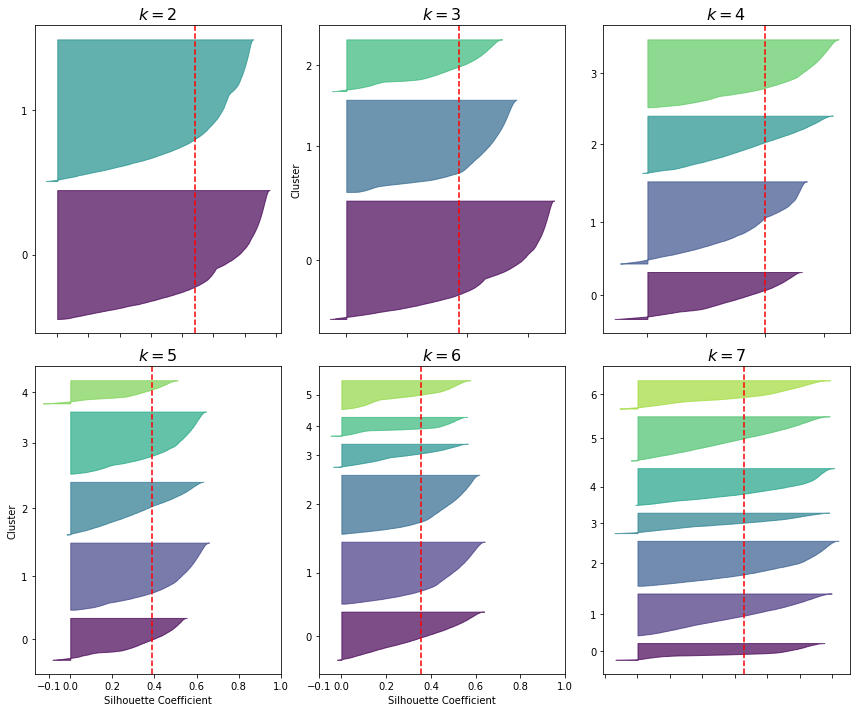

In [116]:
import matplotlib as mpl

plt.figure(figsize=(12,10))

for k in (2,3,4,5,6,7):
    plt.subplot(2,3,k-1)
    
    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coefficients = silhouette_samples(training_dataset, y_pred)
    
    padding = len(training_dataset)//30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        
        color = mpl.cm.viridis(i/k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs)//2)
        pos += len(coeffs) + padding
        
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3,5):
        plt.ylabel('Cluster')
        
    if k in(5,6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel('Silhouette Coefficient')
        
    else:
        plt.tick_params(labelbottom=False)
        
    plt.axvline(x=silhouette_scores[k-1], color='red', linestyle='--')
    plt.title('$k={}$'.format(k), fontsize=16)
    
plt.show()

## Run K-means for statistics and facet plot

In [117]:
kmeans = cluster.KMeans(n_clusters=5)
k5cls = kmeans.fit(training_dataset)

In [118]:
training_dataset['k5cls'] = k5cls.labels_

In [119]:
k5sizes = training_dataset.groupby('k5cls').size()
k5sizes


k5cls
0    10852
1    10064
2     3740
3     6779
4     8500
dtype: int64

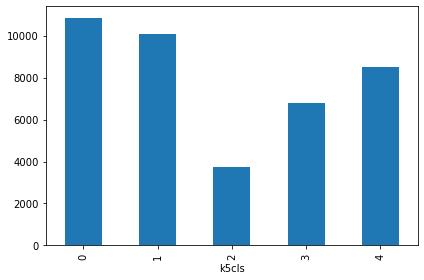

In [120]:
_ = k5sizes.plot.bar()

In [121]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
clustering_var = ['Blue',
                 'Green',
                 'Red',
                 'NIR',
                 'NDVI',
                 'SAVI',
                 'DEM',
                 'Slope',
                 'Aspect',
                 'LULC']

k5means = training_dataset.groupby('k5cls')[clustering_var].mean()
k5means.T.round(3)

k5cls       0      1      2      3      4
Blue    0.118  0.123  0.136  0.140  0.111
Green   0.104  0.110  0.127  0.133  0.098
Red     0.083  0.090  0.127  0.134  0.078
NIR     0.278  0.310  0.265  0.287  0.259
NDVI    0.591  0.599  0.348  0.365  0.578
SAVI    0.834  0.850  0.747  0.798  0.773
DEM     0.277  0.302  0.245  0.242  0.304
Slope   0.287  0.270  0.222  0.254  0.294
Aspect -2.023  2.028 -1.626  1.536 -0.042
LULC    1.005  1.028  2.864  2.864  1.047

In [122]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their descriptive summary


k5desc = training_dataset.groupby('k5cls')[clustering_var].describe()
# Loop over each cluster and print a table with descriptives
for cluster in k5desc.T:
    print('\n\t---------\n\tCluster %i'%cluster)
    print(k5desc.T[cluster].unstack())


	---------
	Cluster 0
          count      mean       std       min       25%       50%       75%  \
Blue    10852.0  0.117678  0.060344  0.025919  0.085409  0.097850  0.119511   
Green   10852.0  0.104019  0.052615  0.019052  0.075036  0.088538  0.111198   
Red     10852.0  0.082956  0.054257  0.008005  0.050735  0.069224  0.093461   
NIR     10852.0  0.278458  0.091354  0.023697  0.214788  0.261750  0.329601   
NDVI    10852.0  0.591297  0.196224  0.000000  0.504122  0.641210  0.725406   
SAVI    10852.0  0.833504  0.360809  0.052215  0.597551  0.773570  1.002351   
DEM     10852.0  0.276841  0.160868  0.001793  0.151592  0.244762  0.399684   
Slope   10852.0  0.286508  0.133873  0.000008  0.185729  0.284963  0.383907   
Aspect  10852.0 -2.022959  0.588951 -3.141593 -2.500027 -1.980402 -1.521328   
LULC    10852.0  1.005252  0.242233  0.000000  1.000000  1.000000  1.000000   

             max  
Blue    0.631731  
Green   0.610538  
Red     0.631827  
NIR     0.733971  
NDVI    0.96

In [123]:
# Index db on cluster ID
tidy_db = training_dataset.set_index('k5cls')
# Keep only variables used for clustering
tidy_db = tidy_db[clustering_var]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

k5cls Attribute    Values
0      3      Blue  0.104518
1      3     Green  0.095559
2      3       Red  0.100183
3      3       NIR  0.151719
4      3      NDVI  0.204705

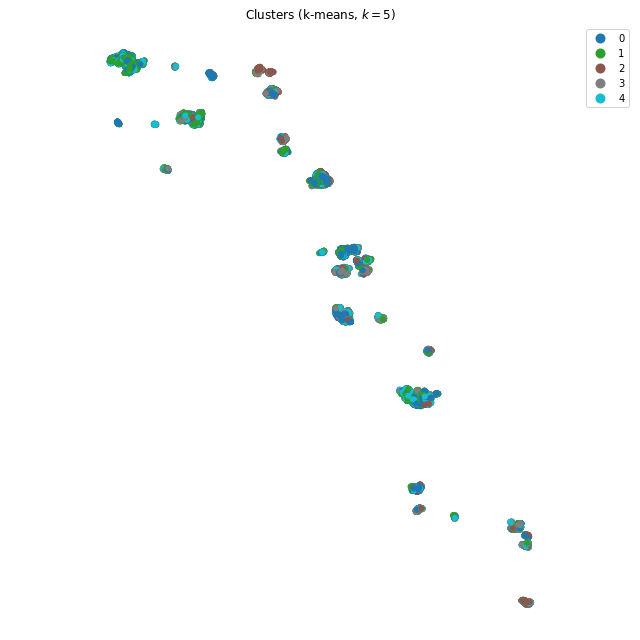

In [124]:
# Assign labels into a column
gdf['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Clusters (k-means, $k=5$)')
# Display the map
plt.show()

## Facet Plot

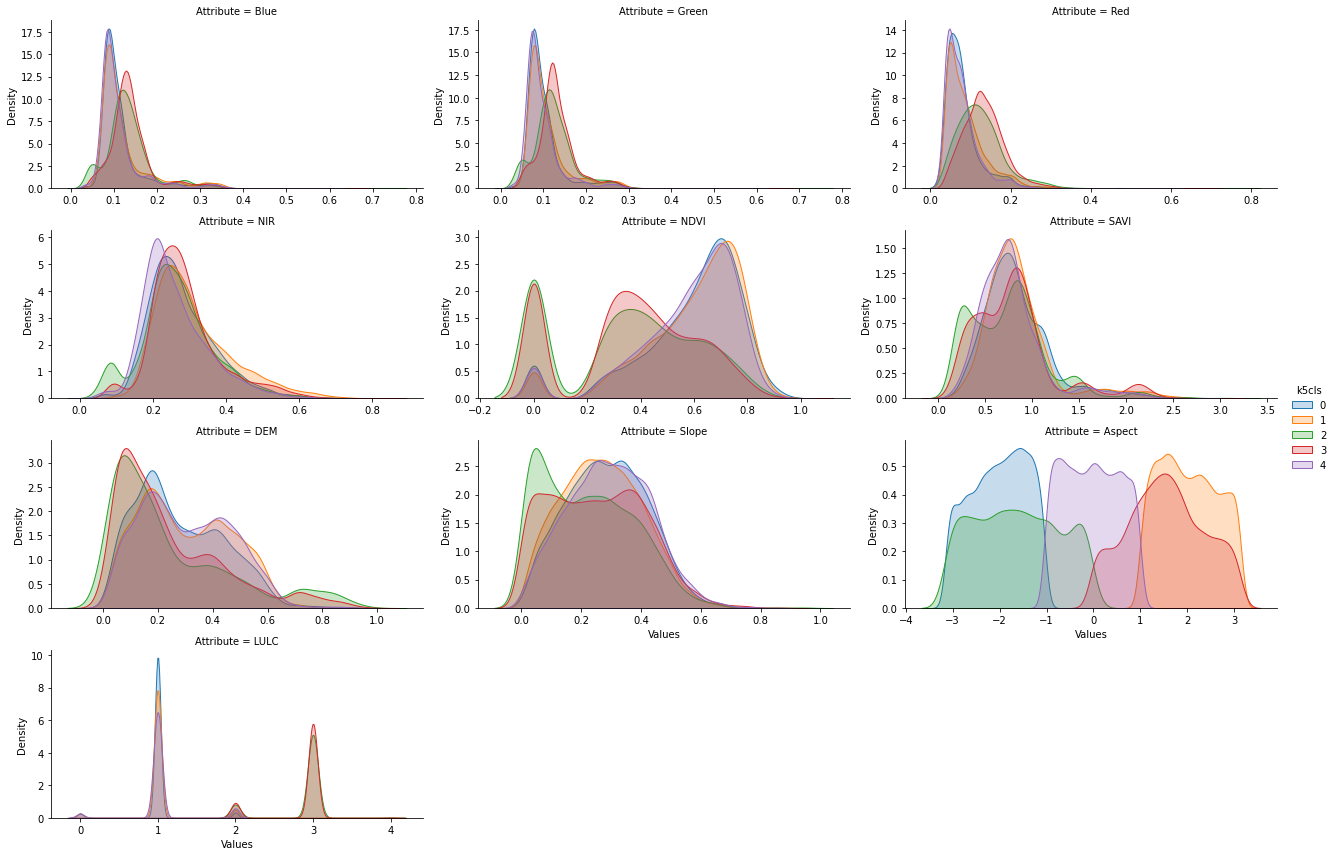

In [125]:
import seaborn
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', hue='k5cls', \
                  sharey=False, sharex=False, aspect=2, col_wrap=3)
# Build the plot from `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()

# Part 3: Data Visualization

In [40]:
path = '/Users/minho/Desktop/CE263/Project/datasets/'

# Input image paths
os.chdir(path)

img_train = sorted(glob.glob('s2*.tif'))
dem_train = sorted(glob.glob('dem*.tif'))
slope_train = sorted(glob.glob('slope*.tif'))
aoi_train = sorted(glob.glob('fire*.tif'))
lulc_train = sorted(glob.glob('lulc*.tif'))

(-0.5, 1578.5, 1433.5, -0.5)

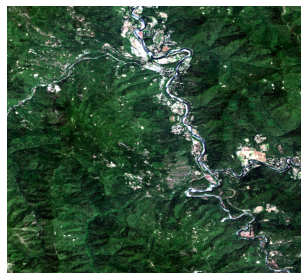

In [41]:
img, _ = open_multiband(img_train[3])
plt.imshow(clip(np.dstack((img[:,:,2], img[:,:,1], img[:,:,0])),2))
plt.axis('off')

(-0.5, 1578.5, 1433.5, -0.5)

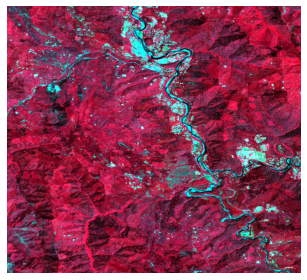

In [42]:
plt.imshow(clip(np.dstack((img[:,:,3], img[:,:,2], img[:,:,1])),2))
plt.axis('off')

(-0.5, 1578.5, 1433.5, -0.5)

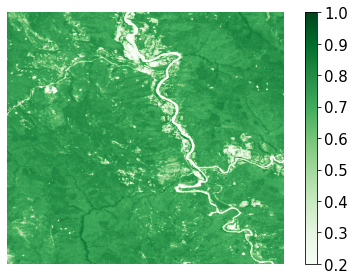

In [43]:
plt.imshow((img[:,:,3]/65535 - img[:,:,2]/65535)/(img[:,:,3]/65535 + img[:,:,2]/65535), cmap='Greens', vmin=0.2,vmax=1)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.axis('off')

(-0.5, 1578.5, 1433.5, -0.5)

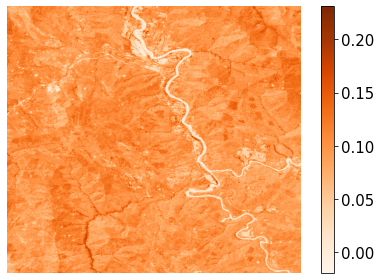

In [44]:
plt.imshow(((img[:,:,3]/65535 - img[:,:,2]/65535) / (img[:,:,3]/65535 +img[:,:,2]/65535 +0.5))*(1+0.5), cmap='Oranges')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=15)


plt.axis('off')


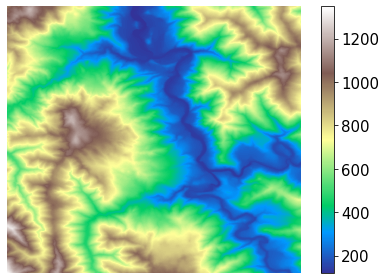

In [45]:
dem_img, _ = open_data(dem_train[3])
plt.imshow(dem_img, cmap='terrain')
plt.axis('off')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=15)

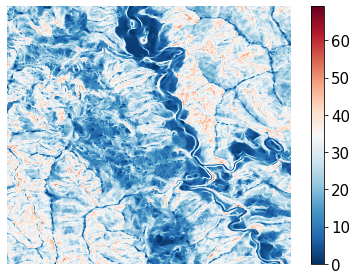

In [46]:
slope_img, _ = open_data(slope_train[3])
plt.imshow(slope_img, cmap='RdBu_r')
plt.axis('off')

cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=15)



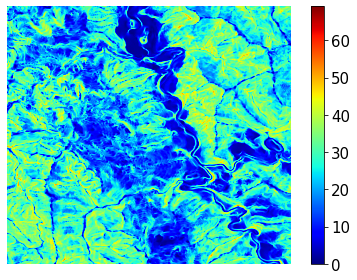

In [47]:
aspect_img, _ = open_data(slope_train[3])
plt.imshow(aspect_img, cmap='jet')
plt.axis('off')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=15)


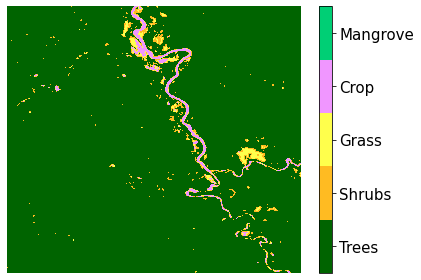

In [50]:
lulc_img, _ = open_data(lulc_train[3])

cmap = matplotlib.colors.ListedColormap([
                                        '#006400',
                                        '#ffbb22',
                                        '#ffff4c',
                                        '#f096ff',
#                                         '#fa0000', #builtup
#                                         '#b4b4b4', #barren sparse veg
#                                         '#f0f0f0', #snow+ice
#                                         '#0064c8', #open water
#                                         '#0096a0', #herbaceous wetland
                                        '#00cf75',
#                                         '#fae6a0' # moss and lichen
                                        ])
boundaries = [10, 20, 30, 40, 95, 100]
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)

im = plt.imshow(lulc_img, cmap=cmap, norm=norm)
plt.axis('off')
cbar = plt.colorbar(im)
# plt.colorbar().set_label(size=15)
cbar.set_ticks([15, 25, 35, 67.5, 97.5])
cbar.ax.tick_params(labelsize=15)
cbar.set_ticklabels(['Trees','Shrubs','Grass','Crop','Mangrove'])




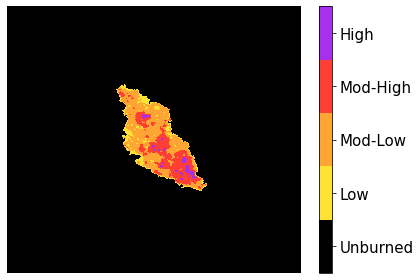

In [51]:
aoi_img, _ = open_data(aoi_train[3])

cmap = matplotlib.colors.ListedColormap(['#000000','#FFE333','#FFA533','#FF3F33','#A730EC'])

aoi_img[aoi_img > 4] = 0
aoi_img[aoi_img < 1] = 0

im=plt.imshow(aoi_img, cmap=cmap, vmin=0, vmax=4)
plt.axis('off')

cbar = plt.colorbar(im)
# plt.colorbar().set_label(size=15)
cbar.set_ticks([0.4, 1.2, 2, 2.8, 3.6])
cbar.ax.tick_params(labelsize=15)
cbar.set_ticklabels(['Unburned','Low','Mod-Low','Mod-High','High'])


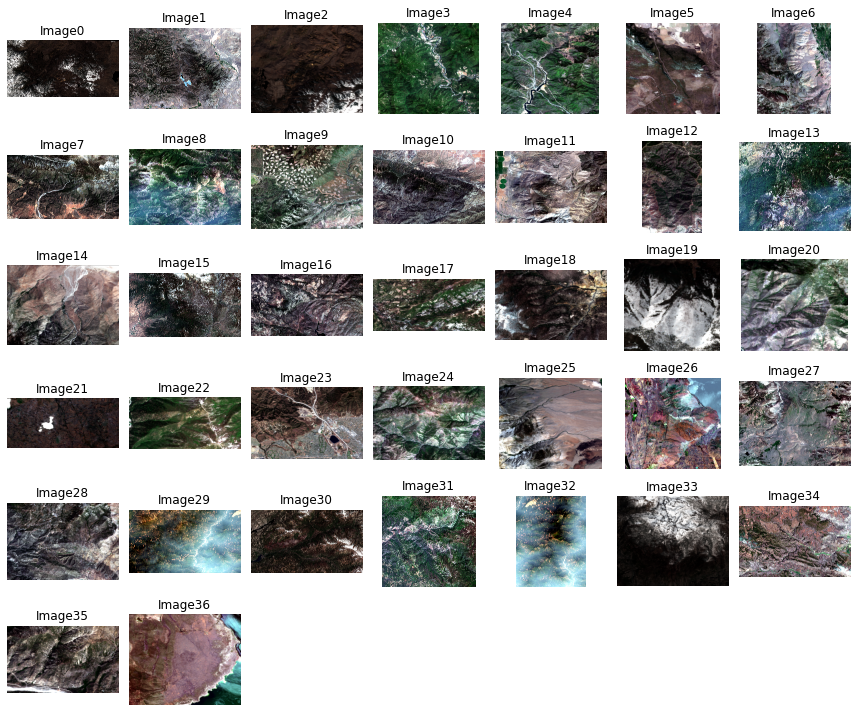

In [52]:
fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(img_train):
    img, _ = open_multiband(x)

    axs[num].imshow(clip(np.dstack((img[:,:,2], img[:,:,1], img[:,:,0])),2))
    axs[num].set_title(str('Image') + str(num))
    axs[num].axis('off')    


axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

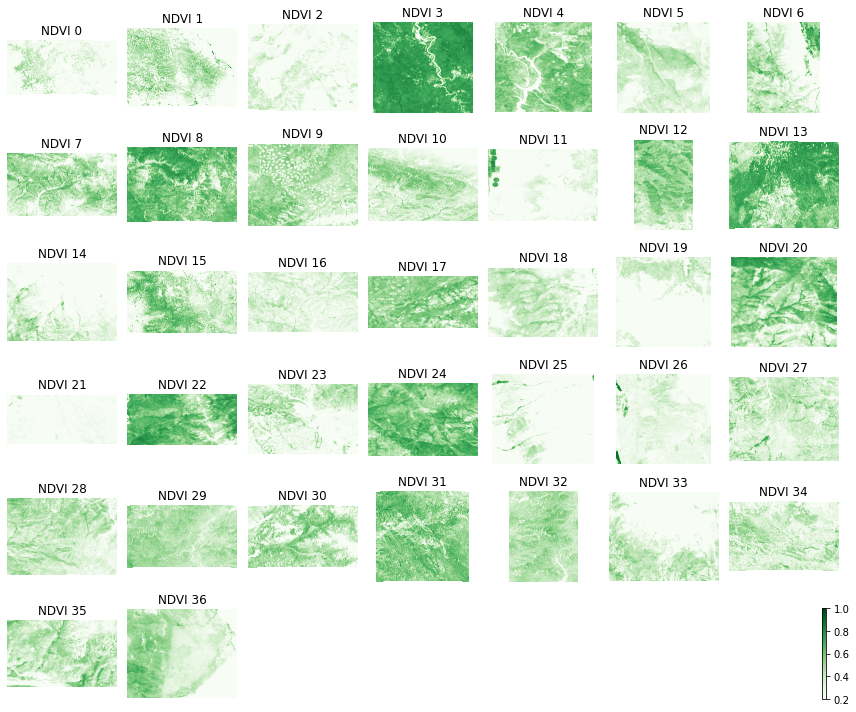

In [53]:
fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(img_train):
    img, _ = open_multiband(x)

    im = axs[num].imshow((img[:,:,3]/65535 - img[:,:,2]/65535)/(img[:,:,3]/65535 + img[:,:,2]/65535), cmap='Greens', vmin=0.2,vmax=1)
    axs[num].set_title(str('NDVI ') + str(num))
    axs[num].axis('off')    
    
fig.colorbar(im)

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

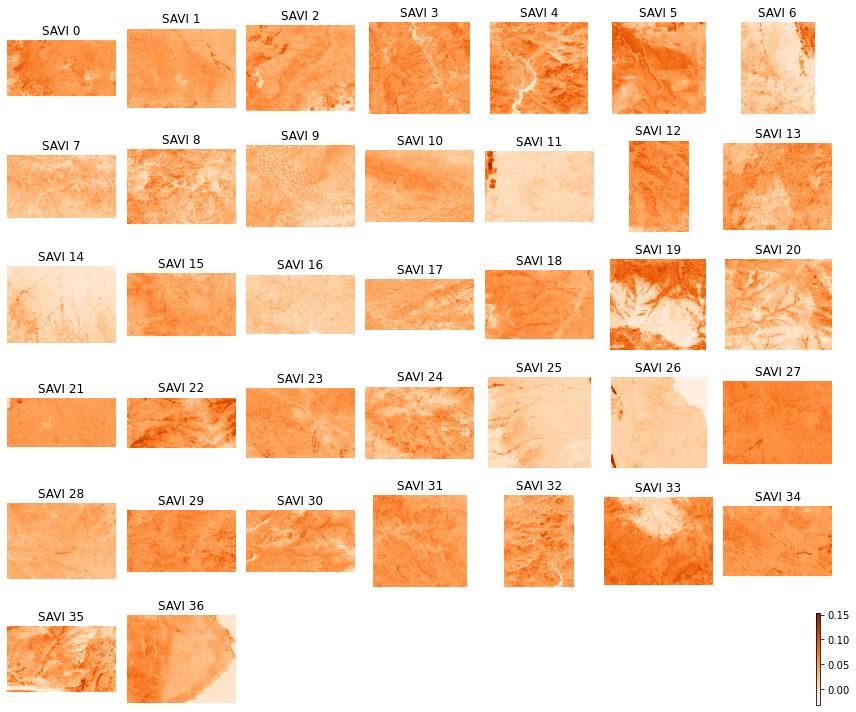

In [54]:
fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(img_train):
    img, _ = open_multiband(x)

    im = axs[num].imshow(((img[:,:,3]/65535 - img[:,:,2]/65535) / (img[:,:,3]/65535 +img[:,:,2]/65535 +0.5))*(1+0.5), cmap='Oranges')
    axs[num].set_title(str('SAVI ') + str(num))
    axs[num].axis('off')    

fig.colorbar(im)

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

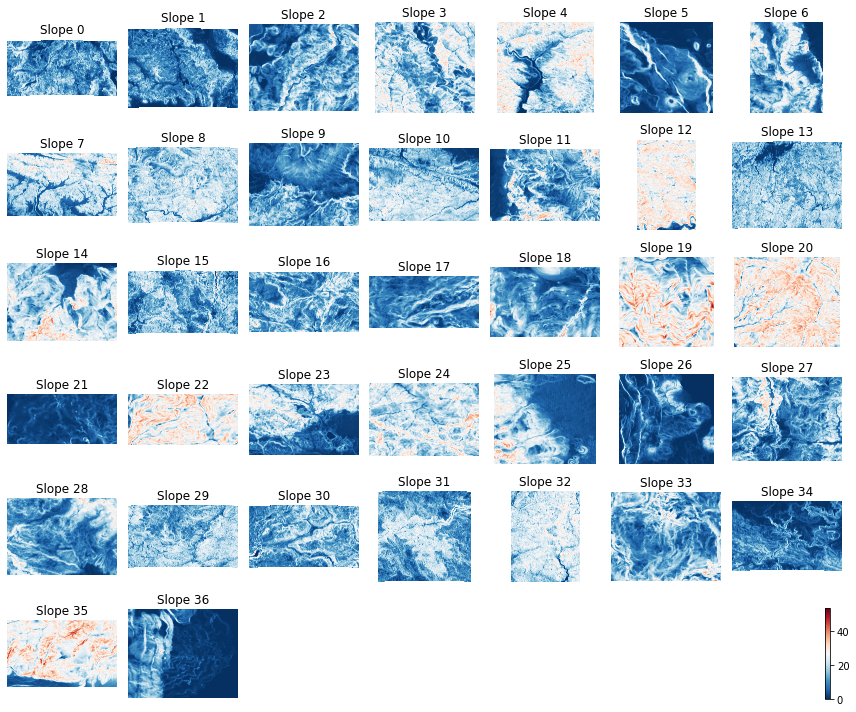

In [55]:
fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(slope_train):
    img, _ = open_data(x)

    im = axs[num].imshow(img, cmap='RdBu_r')
    axs[num].set_title(str('Slope ') + str(num))
    axs[num].axis('off')    

fig.colorbar(im)

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

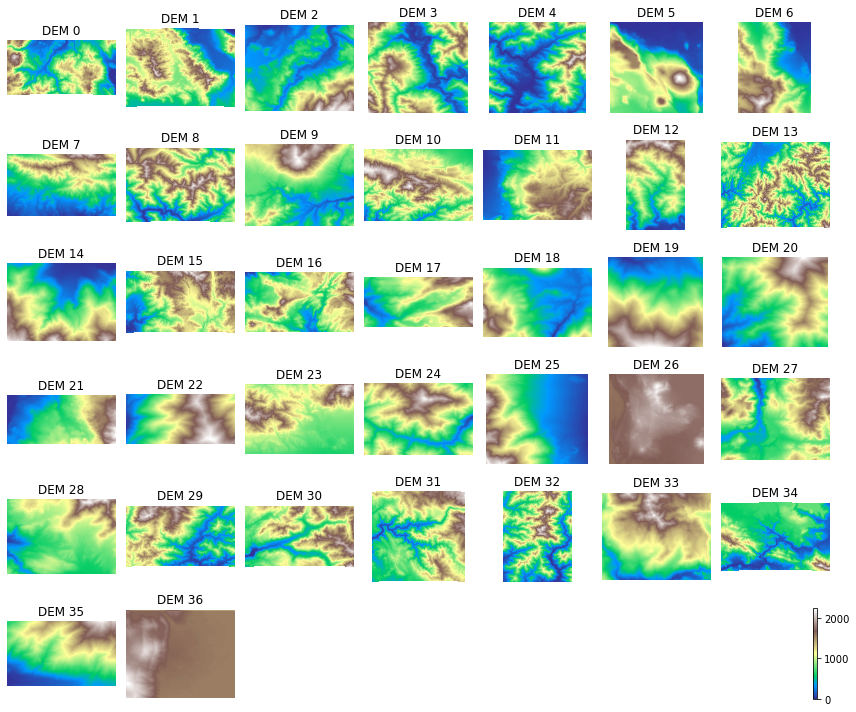

In [56]:
fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(dem_train):
    img, _ = open_data(x)

    im = axs[num].imshow(img, cmap='terrain')
    axs[num].set_title(str('DEM ') + str(num))
    axs[num].axis('off')    

fig.colorbar(im)

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

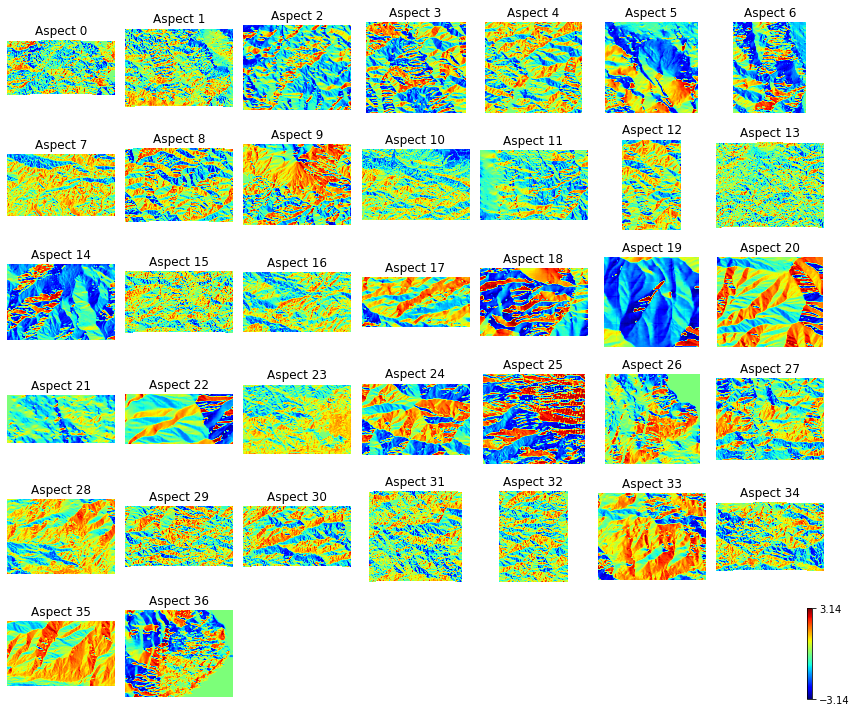

In [57]:
fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(dem_train):
    img, _ = open_data(x)

    x, y = np.gradient(img)
    aspect = np.arctan2(-x, y)
    
    im = axs[num].imshow(aspect, cmap='jet')
    axs[num].set_title(str('Aspect ') + str(num))
    axs[num].axis('off')    

cbar = fig.colorbar(im, ticks=(-3.14,3.14))

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

fig.tight_layout()

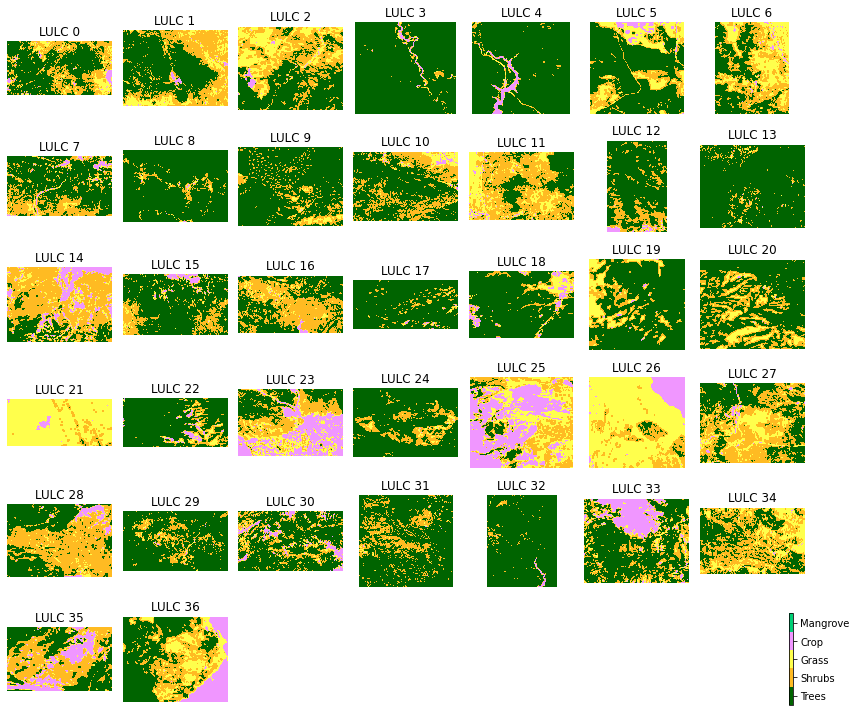

In [58]:
cmap = matplotlib.colors.ListedColormap([
                                        '#006400',
                                        '#ffbb22',
                                        '#ffff4c',
                                        '#f096ff',
#                                         '#fa0000', #builtup
#                                         '#b4b4b4', #barren sparse veg
#                                         '#f0f0f0', #snow+ice
#                                         '#0064c8', #open water
#                                         '#0096a0', #herbaceous wetland
                                        '#00cf75',
#                                         '#fae6a0' # moss and lichen
                                        ])
boundaries = [10, 20, 30, 40, 95, 100]
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)


fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(lulc_train):
    img, _ = open_data(x)
#     img[[img != 10] or [img != 20] or [img != 30] or [img != 40] or [img != 95]]= 0
#     img[img > 1] = 0

    im = axs[num].imshow(img, cmap=cmap, norm=norm)
    
    axs[num].set_title(str('LULC ') + str(num))
    axs[num].axis('off')    

    
cbar = fig.colorbar(im)
cbar.set_ticks([15, 25, 35, 67.5, 97.5])
cbar.set_ticklabels(['Trees','Shrubs','Grass','Crop','Mangrove'])


axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

#     fig.colorbar.set_ticks([0,1,2,3,4])
#     cbar.set_ticklabels(['0','1','2','3','4'])

fig.tight_layout()

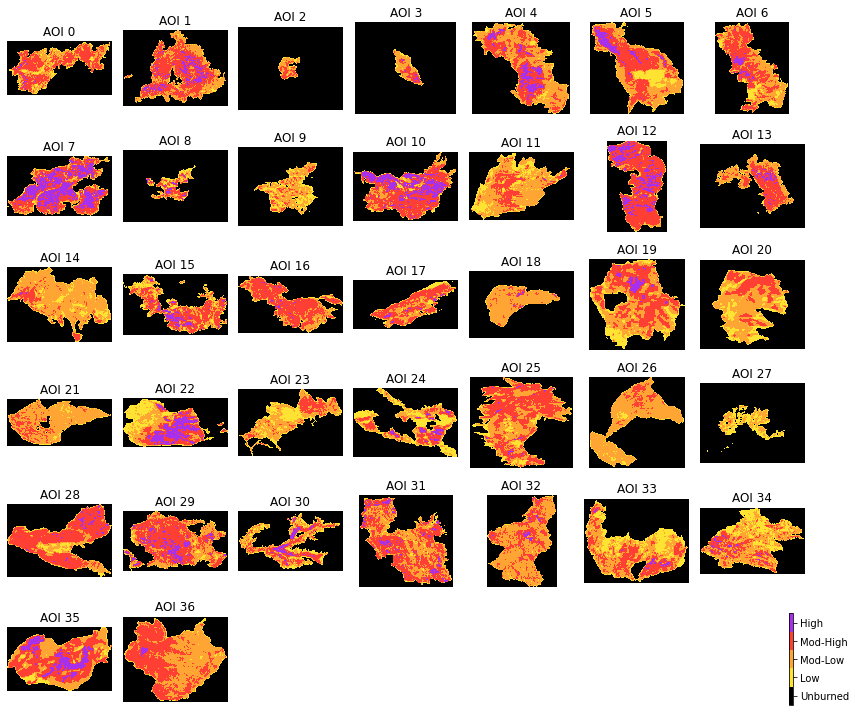

In [59]:
cmap = matplotlib.colors.ListedColormap(['#000000','#FFE333','#FFA533','#FF3F33','#A730EC'])

fig, axs = plt.subplots(6,7, figsize=(12, 10))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for num, x in enumerate(aoi_train):
    img, _ = open_data(x)
    img[img > 4] = 0
    img[img < 1] = 0

    im = axs[num].imshow(img, cmap=cmap, vmin=0, vmax=4)
    axs[num].set_title(str('AOI ') + str(num))
#    aoi_train[num].split('fire')[1].split('_')[0])
    axs[num].axis('off')    

cbar = fig.colorbar(im)
cbar.set_ticks([0.4, 1.2, 2, 2.8, 3.6])
cbar.set_ticklabels(['Unburned','Low','Mod-Low','Mod-High','High'])

axs.flat[-1].set_visible(False) # to remove last plot
axs.flat[-2].set_visible(False) # to remove last plot
axs.flat[-3].set_visible(False) # to remove last plot
axs.flat[-4].set_visible(False) # to remove last plot
axs.flat[-5].set_visible(False) # to remove last plot

#     fig.colorbar.set_ticks([0,1,2,3,4])
#     cbar.set_ticklabels(['0','1','2','3','4'])

fig.tight_layout()